# Modelling Wands

In this notebook, I will attempt to build a bottom-up model to predict log-prices of poe2 `weapon.wand` items using data scraped from `Rise of Abyssal` and `Standard`.

In [1]:
%load_ext autoreload
%autoreload 2

import random

# Set the seed to an integer value
random.seed(42) 

from __future__ import annotations
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

import nest_asyncio; nest_asyncio.apply()

# debugging ModuleNotFound errors
print("CWD:", os.getcwd())

print("sys.path:")
for p in sys.path:
    print("   ", p)

CWD: /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/src/research/scripts
sys.path:
    /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe
    /opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python313.zip
    /opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13
    /opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload
    
    /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages


In [2]:
from utils import preview_dataset, quick_validation, summarize_feature_set

wand = preview_dataset("/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/weapon_wand_overall_rise_20of_20the_20abyssal.parquet")

Dataset: weapon_wand_overall_rise_20of_20the_20abyssal.parquet
Shape: 753 rows × 46 columns

Columns:
   1. id
   2. league
   3. realm
   4. indexed
   5. seller
   6. fee
   7. price_amount_original
   8. price_currency_original
   9. price_type
  10. price_amount_in_base
  11. price_currency_in_base
  12. price_rate_to_base
  13. verified
  14. rarity
  15. base_type
  16. type_line
  17. name
  18. ilvl
  19. identified
  20. corrupted
  21. duplicated
  22. unmodifiable
  23. category
  24. stack_size
  25. max_stack_size
  26. support
  27. gem_sockets
  28. weapon_requirements
  29. gem_tabs
  30. gem_background
  31. gem_skill
  32. sec_descr_text
  33. flavour_text
  34. descr_text
  35. sockets
  36. properties
  37. requirements
  38. granted_skills
  39. socketed_items
  40. extended
  41. rune_mods
  42. desecrated_mods
  43. implicit_mods
  44. explicit_mods
  45. veiled_mods
  46. desecrated

First 5 rows:
                                                              id 

In [3]:
import pandas as pd

# Set pandas options to display all columns and prevent truncation of text
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column content

# Display the filtered DataFrame
display(wand[(wand['rarity'] == "Unique") & (wand['name'] == '')])


id  \
384  a0d45a99fd2149eae8f7f00b3b61711b0744cc0005ff3aeb2596eea793695f13   
391  7d7c08b54688e0cfde5eb35bf717c2bfac41d9766cb85c7c1fc0ed4ae59d5684   
425  9e34bca60eede751b67abb638f7d5f337a5efdf9749e133fdf0b4422977c84ec   
431  fc8c54170e1c30c7c6b9408ccb64fb319290041c6a25c8831474c1f6d125c66d   
444  043a39bdf165fe53fcfe38677b7d61dbb7014d8b5def6a12ebaa038d3ed8620f   
469  38f00473b51cdc2e42d0569d924bc2f2aad66353e81477e76fdc23f91b93e2ea   
487  871716ceb3ce6b12dbb0cc6e89c716c1d3ec80a0fcd787ee5d5ed38828e2ded3   
497  dd021dfac66d6fe09e3e8712222b9d088e90f320b2f3e13977c1233d4f3dd005   
499  70583f144eb7a07855f020f93a3a55505dee6e24a33168e4b1be0a629bdc0276   

                  league realm               indexed                seller  \
384  Rise of the Abyssal  poe2  2025-09-02T17:54:52Z  KingdomProtista#0915   
391  Rise of the Abyssal  poe2  2025-09-02T17:05:37Z           沉没成本1号#0291   
425  Rise of the Abyssal  poe2  2025-09-02T15:01:32Z          yumaruD#7101   
431  Rise of the Abyssal  poe2  2025-08-31T10:13:41Z       Wjy1912937#1128   
444  Rise of the Abyssal  poe2  2025-09-02T06:31:26Z      wocaonimade#2599   
469  Rise of the Abyssal  poe2  2025-08-31T10:19:19Z            mokou#5891   
487  Rise of the Abyssal  poe2  2025-09-02T16:01:13Z          Lube777#3341   
497  Rise of the Abyssal  poe2  2025-09-02T01:50:49Z          REWALOS#7947   
499  Rise of the Abyssal  poe2  2025-09-01T16:57:22Z          Elnorte#8540   

        fee  price_amount_original price_currency_original price_type  \
384  5126.0                    1.0               Regal Orb       ~b/o   
391  8121.0                    1.0               Regal Orb       ~b/o   
425  5679.0                    1.0             Exalted Orb       ~b/o   
431  6148.0                    1.0             Exalted Orb       ~b/o   
444  6148.0                    3.0             Exalted Orb       ~b/o   
469  5874.0                    1.0               Chaos Orb       ~b/o   
487     NaN                    1.0               Chaos Orb       ~b/o   
497  6148.0                    1.0               Chaos Orb       ~b/o   
499  5679.0                    1.0               Chaos Orb       ~b/o   

     price_amount_in_base price_currency_in_base  price_rate_to_base  \
384              0.543869            Exalted Orb            0.543869   
391              0.543869            Exalted Orb            0.543869   
425              1.000000            Exalted Orb            1.000000   
431              1.000000            Exalted Orb            1.000000   
444              3.000000            Exalted Orb            1.000000   
469              4.715971            Exalted Orb            4.715971   
487              4.715971            Exalted Orb            4.715971   
497              4.715971            Exalted Orb            4.715971   
499              4.715971            Exalted Orb            4.715971   

     verified  rarity      base_type      type_line name  ilvl  identified  \
384      True  Unique      Bone Wand      Bone Wand         38       False   
391      True  Unique     Acrid Wand     Acrid Wand         82       False   
425      True  Unique      Bone Wand      Bone Wand         65       False   
431      True  Unique  Volatile Wand  Volatile Wand         65       False   
444      True  Unique  Volatile Wand  Volatile Wand         65       False   
469      True  Unique   Attuned Wand   Attuned Wand         65       False   
487      True  Unique  Volatile Wand  Volatile Wand         65       False   
497      True  Unique  Volatile Wand  Volatile Wand         65       False   
499      True  Unique      Bone Wand      Bone Wand         65       False   

     corrupted  duplicated  unmodifiable category stack_size max_stack_size  \
384      False       False         False     Wand       None           None   
391      False       False         False     Wand       None           None   
425      False       False         False     Wand       None           None   
431   

In [4]:
display(wand[(wand['rarity'] == "Unique")].name.unique())
display(wand[(wand['rarity'] == "Unique")].base_type.unique())

display(wand[(wand['rarity'] == "Unique") & (wand['name'] == "The Wicked Quill")].base_type.unique())

# Lifesprig = Attuned Wand
# Sanguine Diviner = Bone Wand
# Cursecarver = Acrid Wand
# Enezun's Charge = Volatile Wand
# The Wicket Quill = Withered Wand

array(['Lifesprig', 'Sanguine Diviner', 'Cursecarver', "Enezun's Charge",
       '', 'The Wicked Quill'], dtype=object)

array(['Attuned Wand', 'Bone Wand', 'Acrid Wand', 'Volatile Wand',
       'Withered Wand'], dtype=object)

array(['Withered Wand'], dtype=object)

In [5]:
from utils import combine_parquet_files, summarize_feature_set

file_paths = [
    "/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/weapon_wand_overall_rise_20of_20the_20abyssal.parquet",
    "/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/weapon_wand_overall_standard.parquet"
]

# Output path
output_file = "/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/total/wand.parquet"


combine_parquet_files(file_paths=file_paths, output_file=output_file)

Loading file: /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/weapon_wand_overall_rise_20of_20the_20abyssal.parquet
Loading file: /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/weapon_wand_overall_standard.parquet
Combined DataFrame saved to: /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/total/wand.parquet


In [6]:
df  = pd.read_parquet("/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/total/wand.parquet"
)
len(df[df.rarity != "Unique"])

782

## Feature Preprocessing and Selection

Here, I will preprocess the features by parsing raw poe2 item data into feature sets, segregating the feature sets into "craftables" (normal, magic, and rare) and uniques, dropping columns that have constant variance, and filtering out features that are highly correlated with one another using VIF.

In [ ]:
from features_poex import prepare_feature_sets_from_raw, validate_features
from utils import summarize_feature_set

# Prepare feature sets for craftables
res = prepare_feature_sets_from_raw("/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/total/wand.parquet")
Xc, yc, mc = res["craft_all"]

# Validate features for craftables
validate_features(Xc, yc)

# Summarize feature set for craftables with variance analysis

Dataset: 782 samples, 17 features
Price range: 0.06 - 1.43
Mean price: 0.37, Median: 0.54

key features present:
  open_slots_est: 592 nonzero, avg=3.073
  highest_explicit_tier_num: 621 nonzero, avg=7.506
  highest_explicit_level: 621 nonzero, avg=20.758
  req_level: 769 nonzero, avg=28.717
  req_int: 772 nonzero, avg=51.626
  explicit_mod_count: 621 nonzero, avg=3.246
  other_mods_avg_value: 602 nonzero, avg=19.932
  other_mods_avg_level: 602 nonzero, avg=12.794
  is_corrupted: 117 nonzero, avg=1.000


KeyError: 'unique_by_name'

In [ ]:
from features_poex import prepare_feature_sets_from_raw
from utils import summarize_feature_set

# Get ONLY unique items grouped by name - one line solution
res = prepare_feature_sets_from_raw(
    "/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/training_data/overall/total/wand.parquet",
    group_uniques_by_name=True
)

# Extract just the unique items by name
unique_item_features = res["unique_by_name"]

# Display what you got
print(f"Found {len(unique_item_features)} unique item types:")
for name, (X, y, meta) in unique_item_features.items():
    print(f"  {name}: {len(X)} samples, {X.shape[1]} features")

# Access individual unique items like this:
# unique_item_features["Lifesprig"] -> (features_df, targets_df, metadata_df)
# unique_item_features["Cursecarver"] -> (features_df, targets_df, metadata_df)
# etc.

unique_item_features

Found 5 unique item types:
  Cursecarver: 32 samples, 17 features
  Enezun's Charge: 115 samples, 17 features
  Lifesprig: 106 samples, 17 features
  Sanguine Diviner: 76 samples, 17 features
  The Wicked Quill: 1 samples, 17 features


{'Cursecarver': (     ilvl  socket_count  req_level  req_int  quality  explicit_mod_count  \
  303  44.0           0.0       41.0     74.0      0.0                 5.0   
  305  72.0           0.0       66.0    116.0      0.0                 5.0   
  306  35.0           1.0       33.0     57.0      0.0                 5.0   
  312  61.0           0.0       58.0    103.0      0.0                 5.0   
  314  50.0           0.0       46.0     82.0      0.0                 5.0   
  315  34.0           0.0       33.0     57.0      0.0                 5.0   
  316  61.0           0.0       58.0    103.0      0.0                 5.0   
  333  72.0           0.0       66.0    116.0      0.0                 5.0   
  336  54.0           0.0       52.0     92.0      0.0                 5.0   
  337  65.0           0.0       58.0    103.0      0.0                 5.0   
  346  73.0           0.0       66.0    116.0      0.0                 5.0   
  348  60.0           0.0       58.0    103.0    

In [ ]:
from features_preperation import prepare_design_matrix, validate_design_matrix, print_feature_summary

# Prepare design matrix for craftables (Xc, yc from the previous step)
X_craftable, info_craftable = prepare_design_matrix(
    Xc,
    one_hot_prefixes=(),
    drop_zero_variance=True,
    standardize=True,
    standardize_fit_stats=None, 
    verbose=True,
)

# Save scaler for craftables inference
scaler_craftable = info_craftable["standardize"]

# 3) Validate & summarize for craftables
validate_design_matrix(X_craftable, yc, check_multicollinearity=True)
print_feature_summary(X_craftable)


No zero-variance features found
Standardized 17 numeric columns (fit).

Final feature count: 17

High correlations (>0.99):
  ilvl ↔ req_level: 0.993
Feature Matrix: 782 samples × 17 features

Feature Types:
  numeric: 15
  requirements: 2

Numeric Features: 17 total
  Value range: [-5.98, 14.55]
  Mean variance: 1.0000


In [ ]:
display(wand[(wand['rarity'] == "Unique")].name.unique())
display(wand[(wand['rarity'] == "Unique")].base_type.unique())

display(wand[(wand['rarity'] == "Unique") & (wand['name'] == "The Wicked Quill")].base_type.unique())

# Lifesprig = Attuned Wand
# Sanguine Diviner = Bone Wand
# Cursecarver = Acrid Wand
# Enezun's Charge = Volatile Wand
# The Wicket Quill = Withered Wand

array(['Lifesprig', 'Sanguine Diviner', 'Cursecarver', "Enezun's Charge",
       '', 'The Wicked Quill'], dtype=object)

array(['Attuned Wand', 'Bone Wand', 'Acrid Wand', 'Volatile Wand',
       'Withered Wand'], dtype=object)

array(['Withered Wand'], dtype=object)

In [ ]:
from features_preperation import prepare_design_matrix, validate_design_matrix, print_feature_summary
import pickle

# Prepare design matrices for each unique item and overwrite unique_item_features
for name, (X, y, meta) in unique_item_features.items():
    print(f"Preparing and processing design matrix for unique item: {name}")
    
    # Prepare the design matrix for each unique item (X, y)
    X_unique, info_unique = prepare_design_matrix(
        X,                           # Features for the unique item
        one_hot_prefixes=(),         # No OHE for unique items
        drop_zero_variance=True,
        standardize=True,            # Apply z-score standardization
        standardize_fit_stats=None,  # Fit the scaler for each item
        verbose=True,
    )
    
    # Save the scaler for this unique item (included as part of the info)
    scaler_unique = info_unique["standardize"]
    
    # 3) Validate & summarize for each unique item
    validate_design_matrix(X_unique, y, check_multicollinearity=True)
    print_feature_summary(X_unique)
    
    # Overwrite unique_item_features with the processed design matrix, target, metadata, and scaler
    unique_item_features[name] = {
        "features": X_unique,    # Design matrix for the unique item
        "target": y,             # Target vector for the unique item
        "metadata": meta,        # Metadata for the unique item
        "scaler": scaler_unique  # Scaler for standardization during inference
    }
    
    print(f"Processed and saved design matrix for {name}")

# Now, unique_item_features will contain the processed design matrices, targets, metadata, and scalers for each unique item
print(f"Processed {len(unique_item_features)} unique items.")


Preparing and processing design matrix for unique item: Cursecarver
Dropped 5 zero-variance features:
  quality
  highest_explicit_tier_num
  max_mana
  light_radius
  reduced_requirements
Standardized 12 numeric columns (fit).

Final feature count: 12

Found 21 highly correlated feature pairs
Feature Matrix: 32 samples × 12 features

Feature Types:
  numeric: 10
  requirements: 2

Numeric Features: 12 total
  Value range: [-5.57, 5.57]
  Mean variance: 1.0000
Processed and saved design matrix for Cursecarver
Preparing and processing design matrix for unique item: Enezun's Charge
Dropped 5 zero-variance features:
  highest_explicit_tier_num
  max_mana
  light_radius
  attack_speed_pct
  reduced_requirements
Standardized 12 numeric columns (fit).

Final feature count: 12

High correlations (>0.99):
  explicit_mod_count ↔ other_mods_avg_value: 1.000
  explicit_mod_count ↔ other_mods_avg_level: 1.000
  explicit_mod_count ↔ other_mods_count: 1.000
  explicit_mod_count ↔ highest_explicit_le

In [ ]:
from vif import compute_vif, remove_high_vif_features

X_craftable, _ = remove_high_vif_features(X_craftable)
vif_craftable, analysis_craftable = compute_vif(X_craftable)
# Display VIF values for craftables
print("VIF for Craftables:")
print(vif_craftable)

Iteration 1: removed 'req_int' (VIF=175.54); 16 features remain.
Iteration 2: removed 'ilvl' (VIF=71.73); 15 features remain.
Iteration 3: removed 'explicit_mod_count' (VIF=43.04); 14 features remain.
Iteration 4: removed 'open_slots_est' (VIF=14.66); 13 features remain.
Converged after 4 iterations (max VIF = 8.78 ≤ 10.0).
Final max VIF: 8.78
VIF Analysis Summary:
Total features: 13
High multicollinearity (VIF > 10.0): 0
Moderate multicollinearity (5 < VIF <= 10.0): 2
Max VIF: 8.78
Mean VIF: 2.44

Multicollinearity detected: False
VIF for Craftables:
                      feature       VIF  tolerance
7      highest_explicit_level  8.779374   0.113903
4        other_mods_avg_level  5.332427   0.187532
5            other_mods_count  2.446258   0.408788
6   highest_explicit_tier_num  2.303594   0.434104
3        other_mods_avg_value  2.225530   0.449331
1                   req_level  1.845053   0.541990
9                    max_mana  1.688364   0.592289
8                is_corrupted  1.3

In [ ]:
for name, data in unique_item_features.items():
    X_unique = data["features"]
    y_unique = data["target"]
    
    # Compute VIF and remove high VIF features
    X_unique_cleaned, vif_analysis = remove_high_vif_features(X_unique)
    
    # Store cleaned feature matrix back in the dictionary
    unique_item_features[name]["features"] = X_unique_cleaned
    
    # Optionally, display or store the VIF analysis for reference
    print(f"VIF for {name}:")
    print(vif_analysis)
    print(f"Number of features after VIF removal: {X_unique_cleaned.shape[1]}")


Iteration 1: removed 'explicit_mod_count' (VIF=inf); 11 features remain.
Iteration 2: removed 'other_mods_avg_value' (VIF=inf); 10 features remain.
Iteration 3: removed 'other_mods_avg_level' (VIF=inf); 9 features remain.
Iteration 4: removed 'other_mods_count' (VIF=inf); 8 features remain.
Iteration 5: removed 'highest_explicit_level' (VIF=inf); 7 features remain.
Iteration 6: removed 'attack_speed_pct' (VIF=inf); 6 features remain.
Iteration 7: removed 'req_level' (VIF=1415.43); 5 features remain.
Iteration 8: removed 'req_int' (VIF=61.27); 4 features remain.
Converged after 8 iterations (max VIF = 1.12 ≤ 10.0).
Final max VIF: 1.12
VIF for Cursecarver:
[('explicit_mod_count', inf), ('other_mods_avg_value', inf), ('other_mods_avg_level', inf), ('other_mods_count', inf), ('highest_explicit_level', inf), ('attack_speed_pct', inf), ('req_level', 1415.4313518401332), ('req_int', 61.266697001617125)]
Number of features after VIF removal: 4
Iteration 1: removed 'explicit_mod_count' (VIF=inf

/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1.

## Modelling

Here, I will build a bottom-up model using linear regression. I will first fit a MLR to do a preliminary test to see if a linear model is effective. Afterwards, I will attempt using regularised linear models (ridge and elastic net) to fit the data and obtain the marginal utility of an attribute to the price of a poe2 item.

/Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Cross-Validation (Huber MLR) ===
[Fold 1/5] R² = 0.1192
[Fold 2/5] R² = 0.0613
[Fold 3/5] R² = 0.0638
[Fold 4/5] R² = 0.1158
[Fold 5/5] R² = 0.1042
CV R²: mean=0.0929, std=0.0253

=== Train/Test & Diagnostics ===

[Huber MLR] Holdout metrics:
  r2_train: 0.1366
  r2_test: 0.1192
  rmse_train: 0.1670
  rmse_test: 0.1631
  mae_train: 0.1455
  mae_test: 0.1483


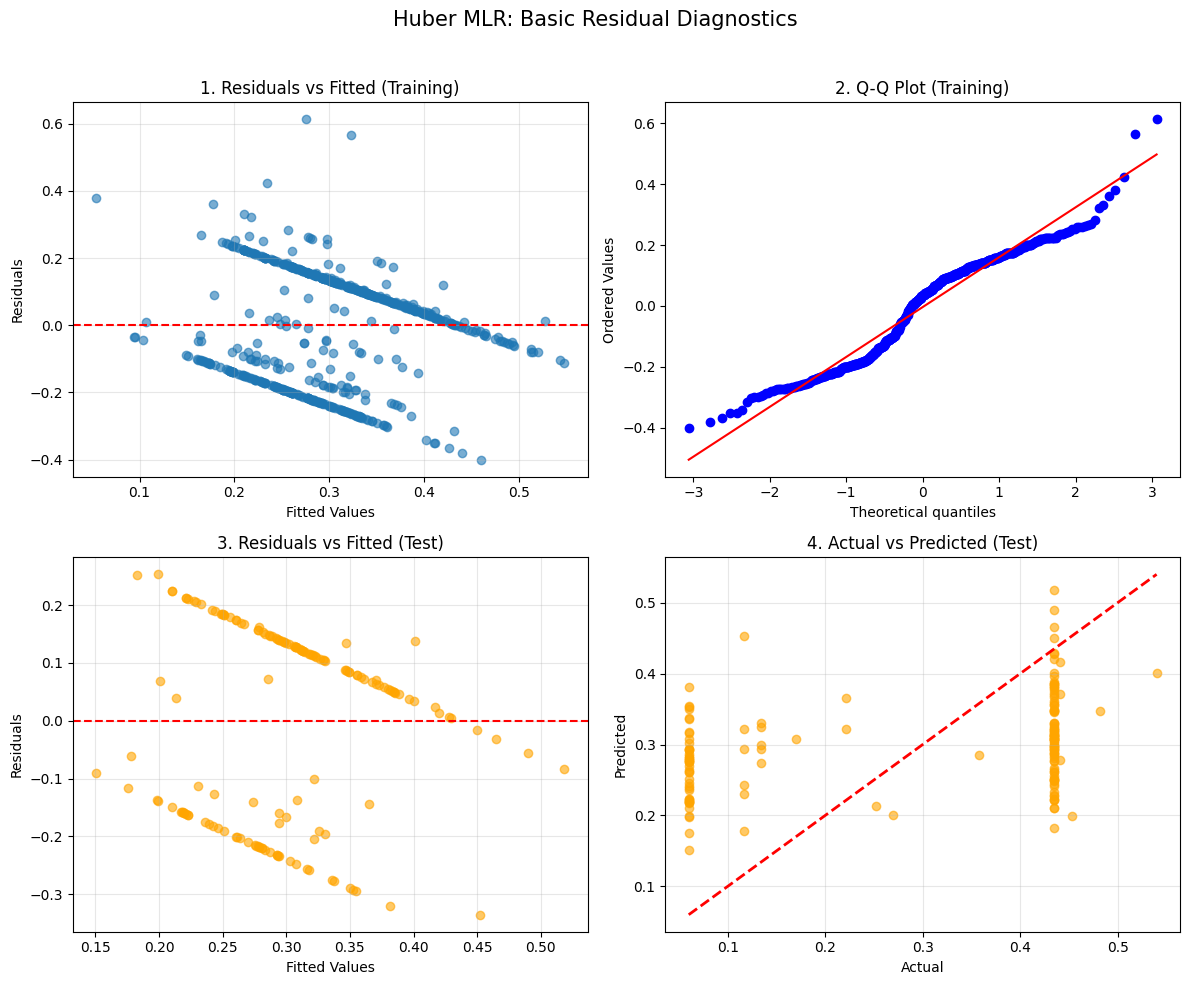


Top coefficients (by |value|):
                  feature  coefficient  abs_coefficient
         other_mods_count     0.066842         0.066842
                req_level    -0.031719         0.031719
             socket_count     0.030777         0.030777
highest_explicit_tier_num    -0.030307         0.030307
     other_mods_avg_level    -0.023413         0.023413
                  quality     0.013315         0.013315
                 max_mana     0.012626         0.012626
         attack_speed_pct    -0.008631         0.008631
     reduced_requirements    -0.007769         0.007769
             light_radius    -0.007021         0.007021
     other_mods_avg_value     0.004867         0.004867
             is_corrupted     0.001521         0.001521
   highest_explicit_level    -0.000294         0.000294
Huber MLR PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.1192
Mean Absolute Error: 0.1483
Root Mean Squared Error: 0.1631


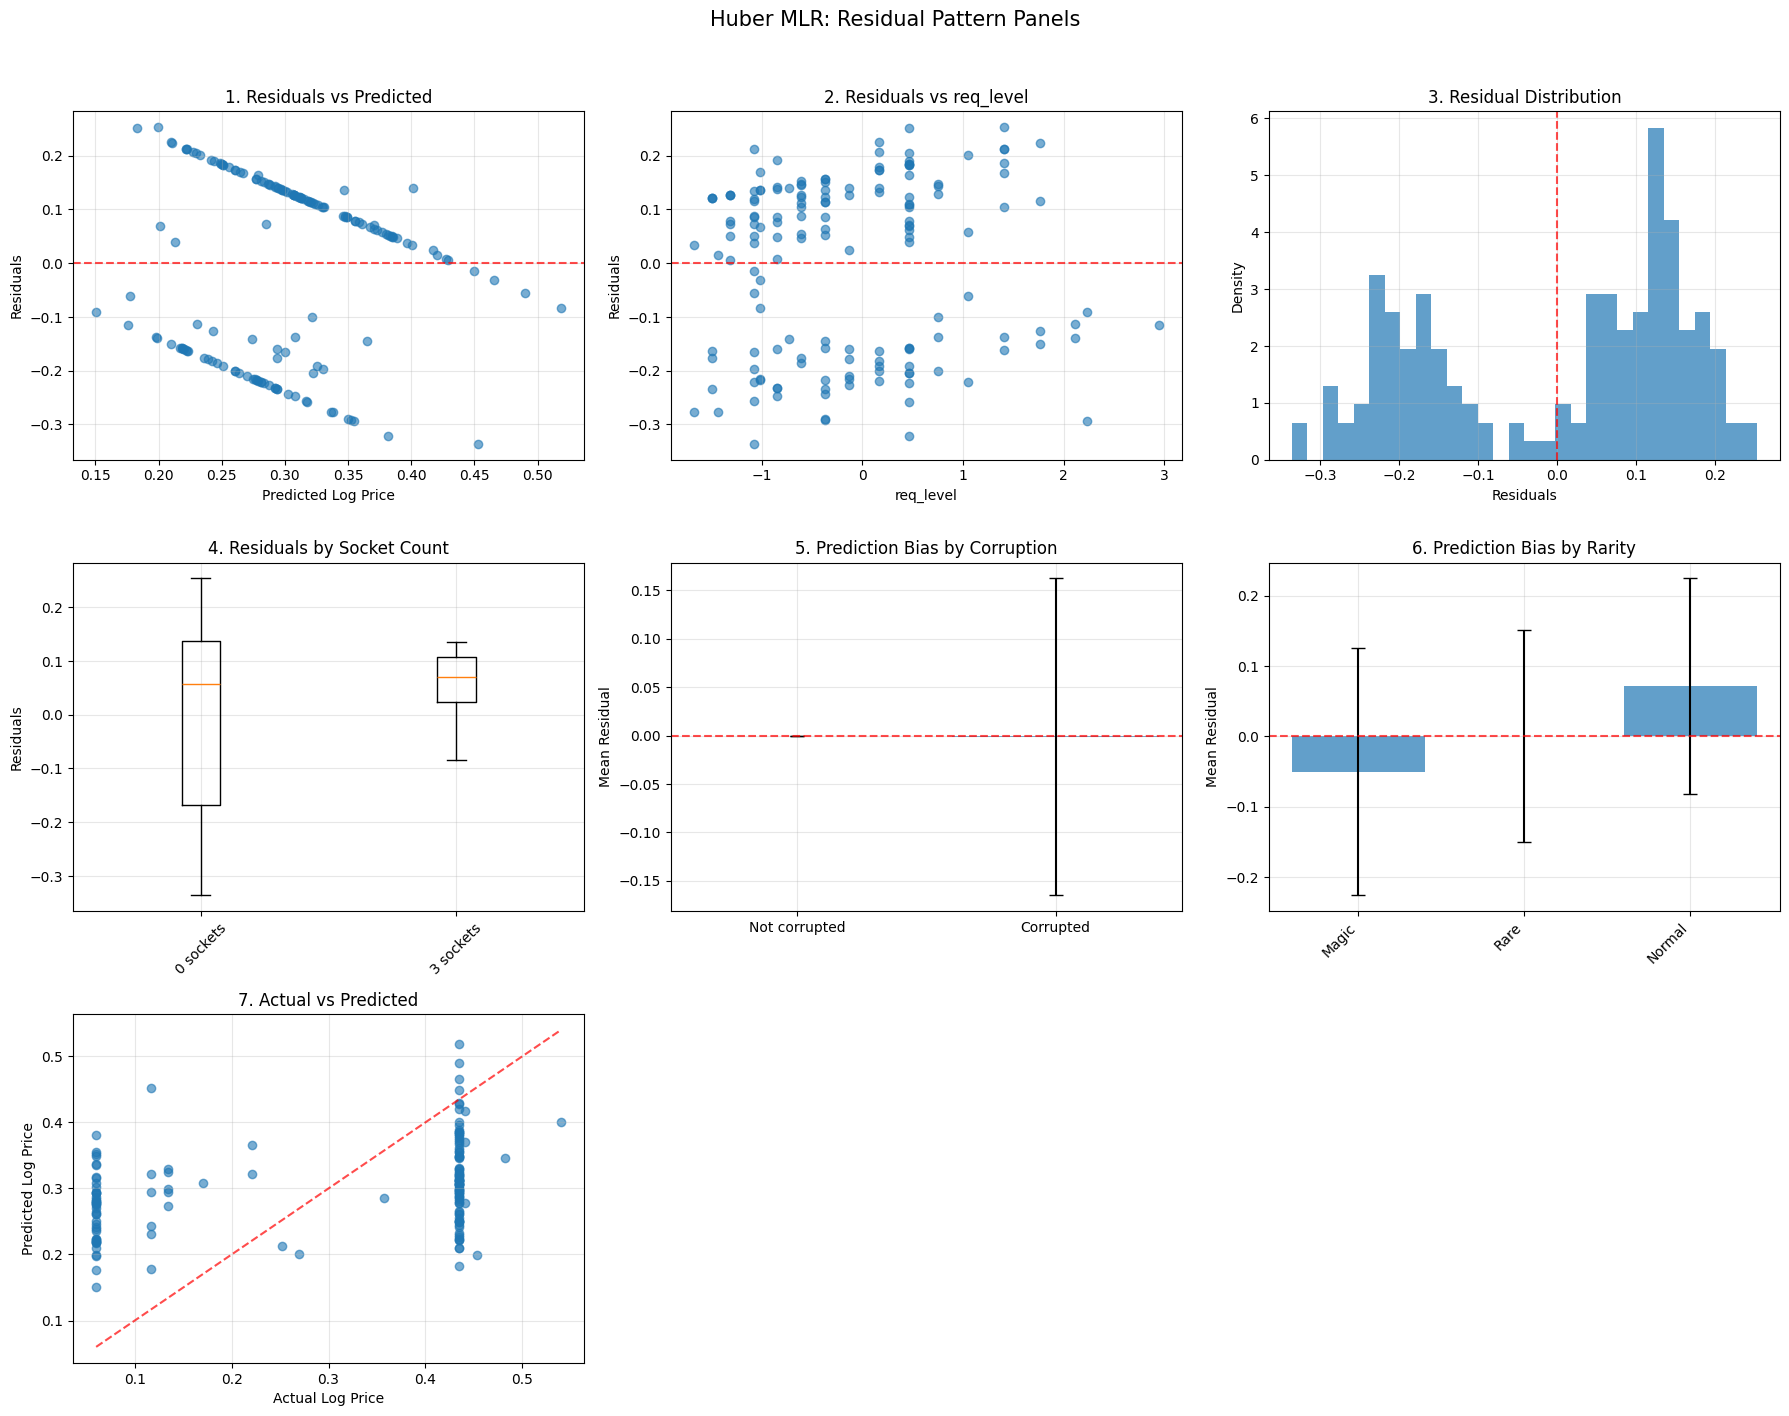

In [ ]:
from modelling import run_huber, compare_regularized_models, run_xgb_shap, decompose_item_with_shap
out_huber = run_huber(X_craftable, yc["log_price"], metadata=mc, cv_splits=5, test_size=0.2, random_state=42)

=== Cross-Validation (Huber MLR) ===
[Fold 1/5] R² = 1.0000
[Fold 2/5] R² = -2276814267495209914549141504.0000
[Fold 3/5] R² = 1.0000
[Fold 4/5] R² = 1.0000
[Fold 5/5] R² = 1.0000
CV R²: mean=-455362853499041996653723648.0000, std=910725706998083855868493824.0000

=== Train/Test & Diagnostics ===

[Huber MLR] Holdout metrics:
  r2_train: 0.7024
  r2_test: 1.0000
  rmse_train: 0.0014
  rmse_test: 0.0000
  mae_train: 0.0003
  mae_test: 0.0000


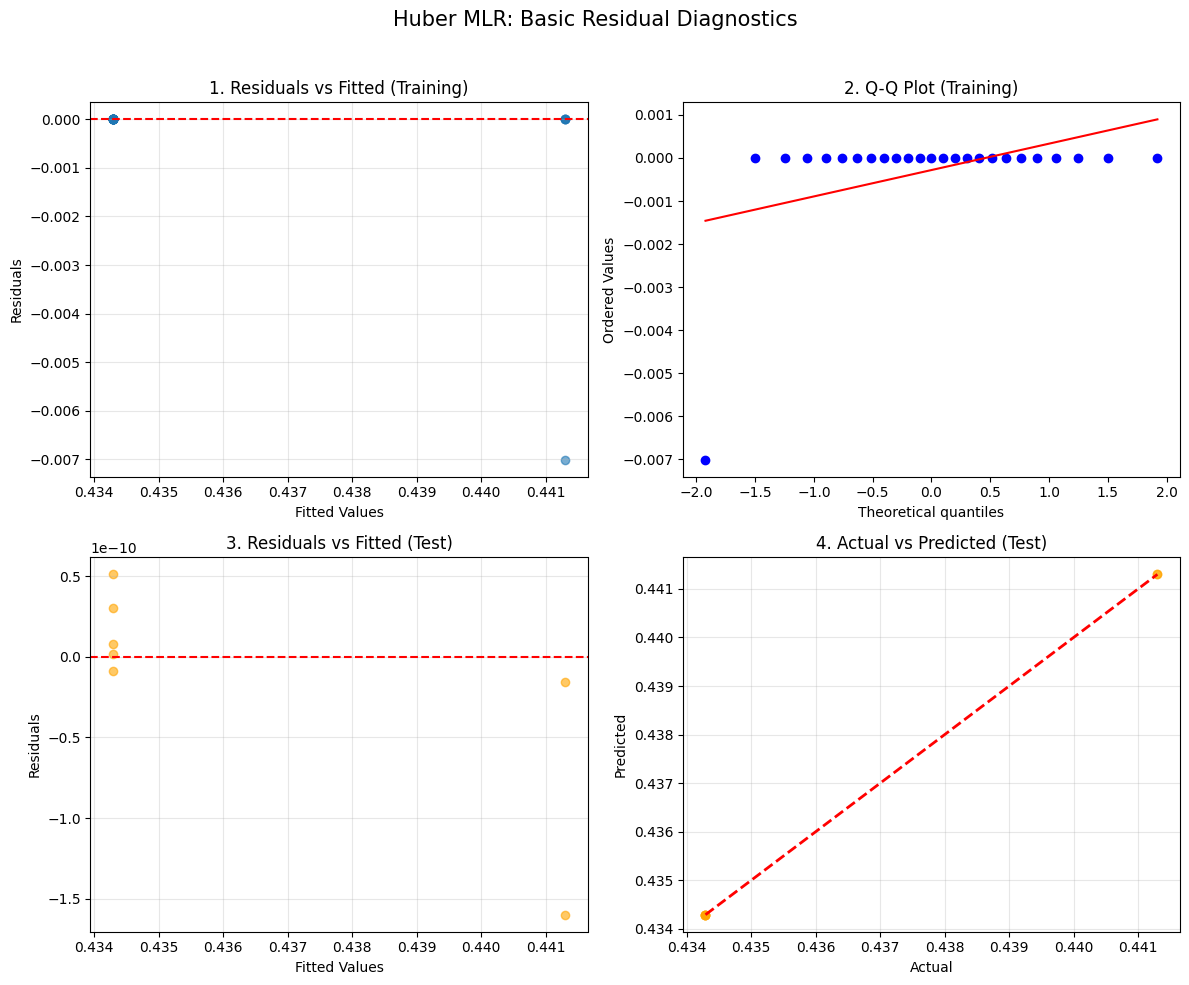


Top coefficients (by |value|):
       feature   coefficient  abs_coefficient
  is_corrupted  2.803193e-03     2.803193e-03
  socket_count  3.627929e-11     3.627929e-11
          ilvl  2.986941e-11     2.986941e-11
open_slots_est -1.943812e-11     1.943812e-11
Huber MLR PERFORMANCE DIAGNOSTICS
Overall Test R²: 1.0000
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000


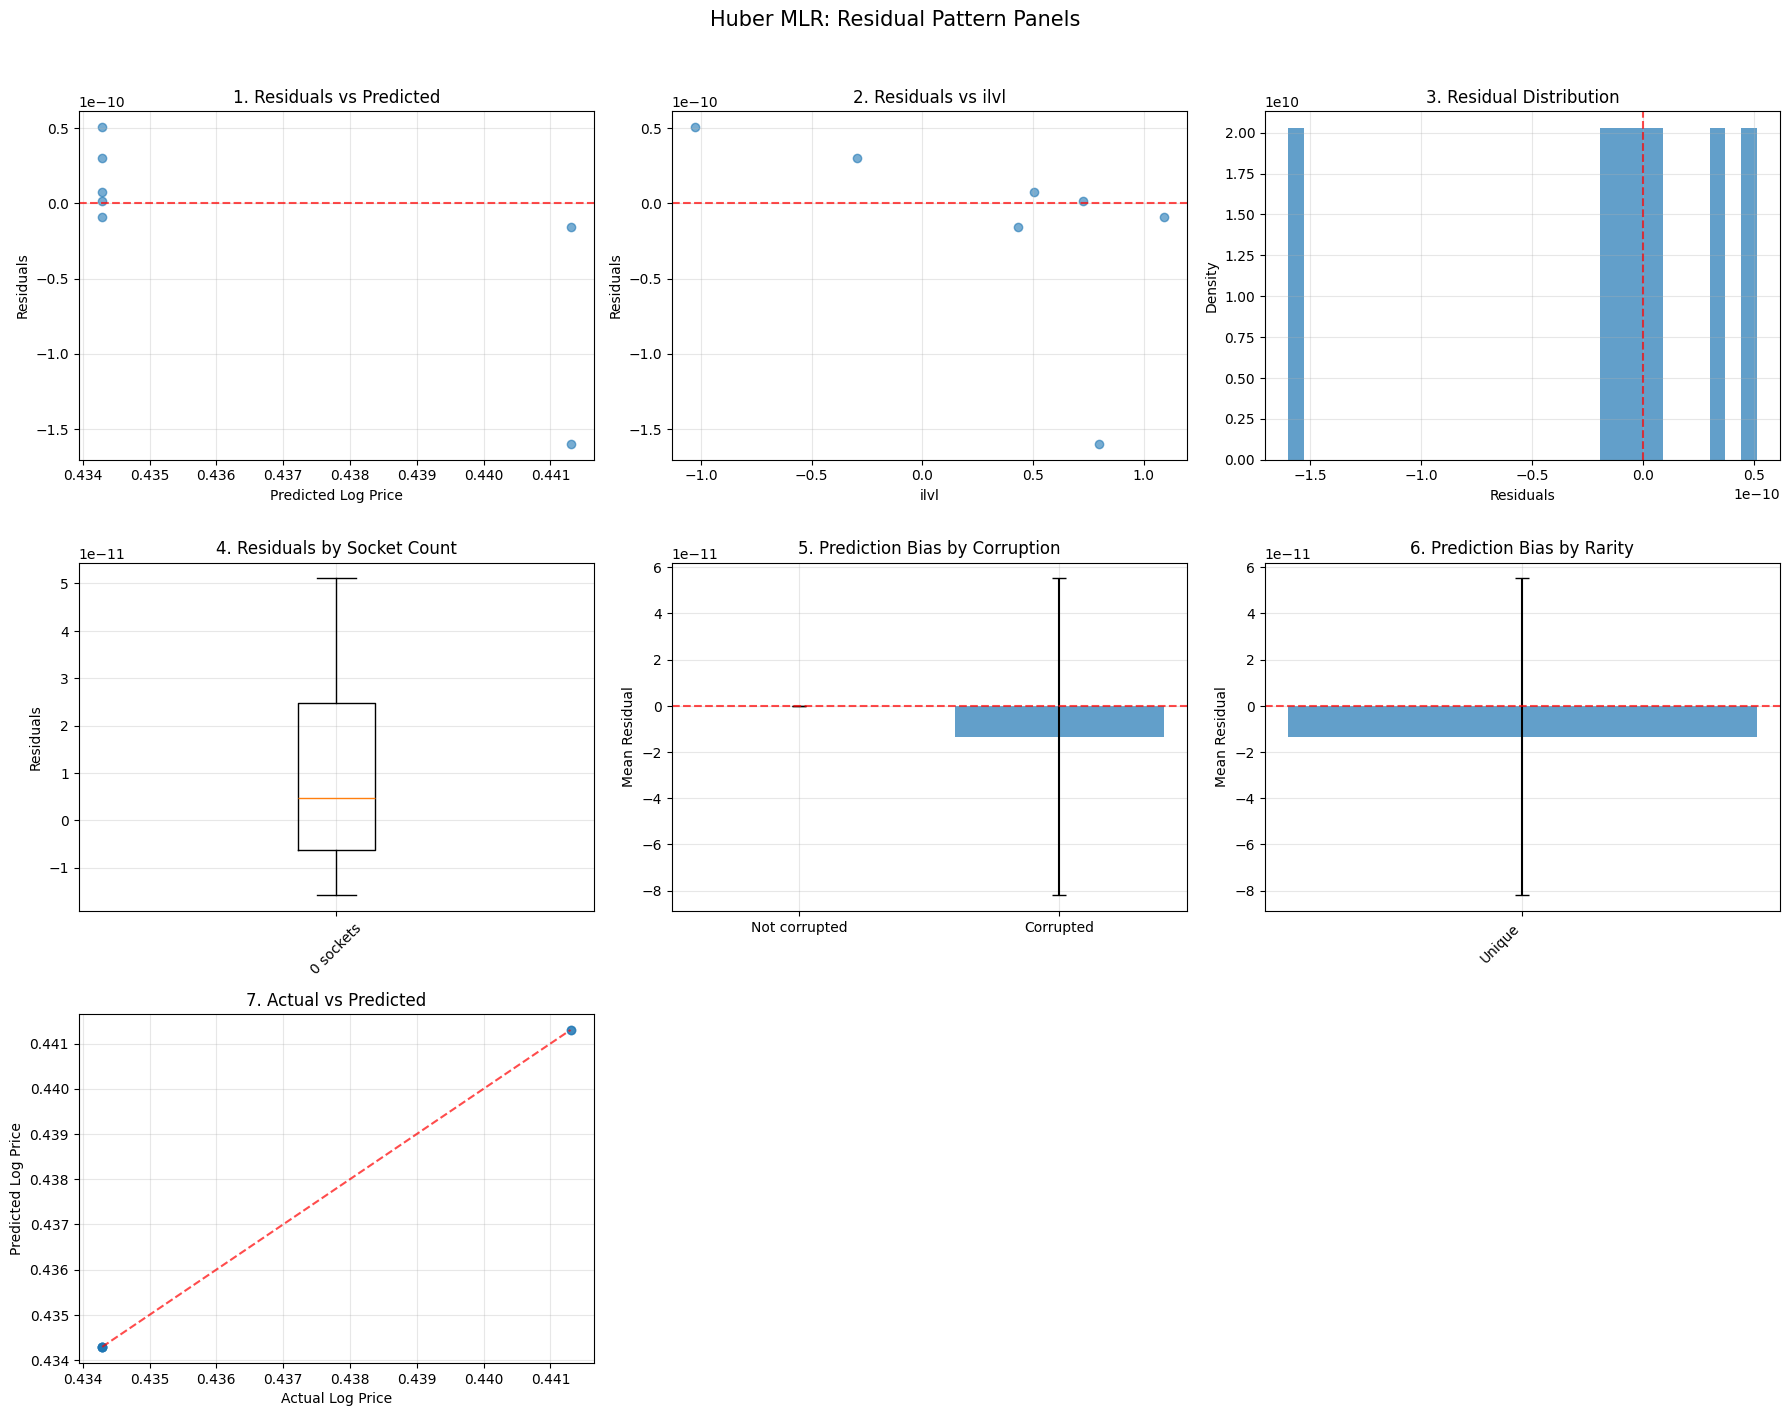

Huber Regression Output for Cursecarver:
{'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('huber', HuberRegressor(alpha=0.0, max_iter=5000))]), 'X_train':          ilvl  socket_count  is_corrupted  open_slots_est
594 -1.464685     -0.321634      1.889822       -0.179605
361  0.579486     -0.321634     -0.529150       -0.179605
303 -1.026648     -0.321634     -0.529150       -0.179605
314 -0.588612     -0.321634     -0.529150       -0.179605
374  0.652492      3.109126     -0.529150       -0.179605
315 -1.756709     -0.321634     -0.529150       -0.179605
364 -0.588612     -0.321634     -0.529150       -0.179605
348  0.141449     -0.321634     -0.529150       -0.179605
394  0.506480     -0.321634     -0.529150       -0.179605
305  1.017523     -0.321634     -0.529150       -0.179605
306 -1.683703      3.109126     -0.529150       -0.179605
628  0.287462     -0.321634      1.889822       -0.179605
312  0.214455     -0.321634     -0.529150       -0.179605
389  0.50

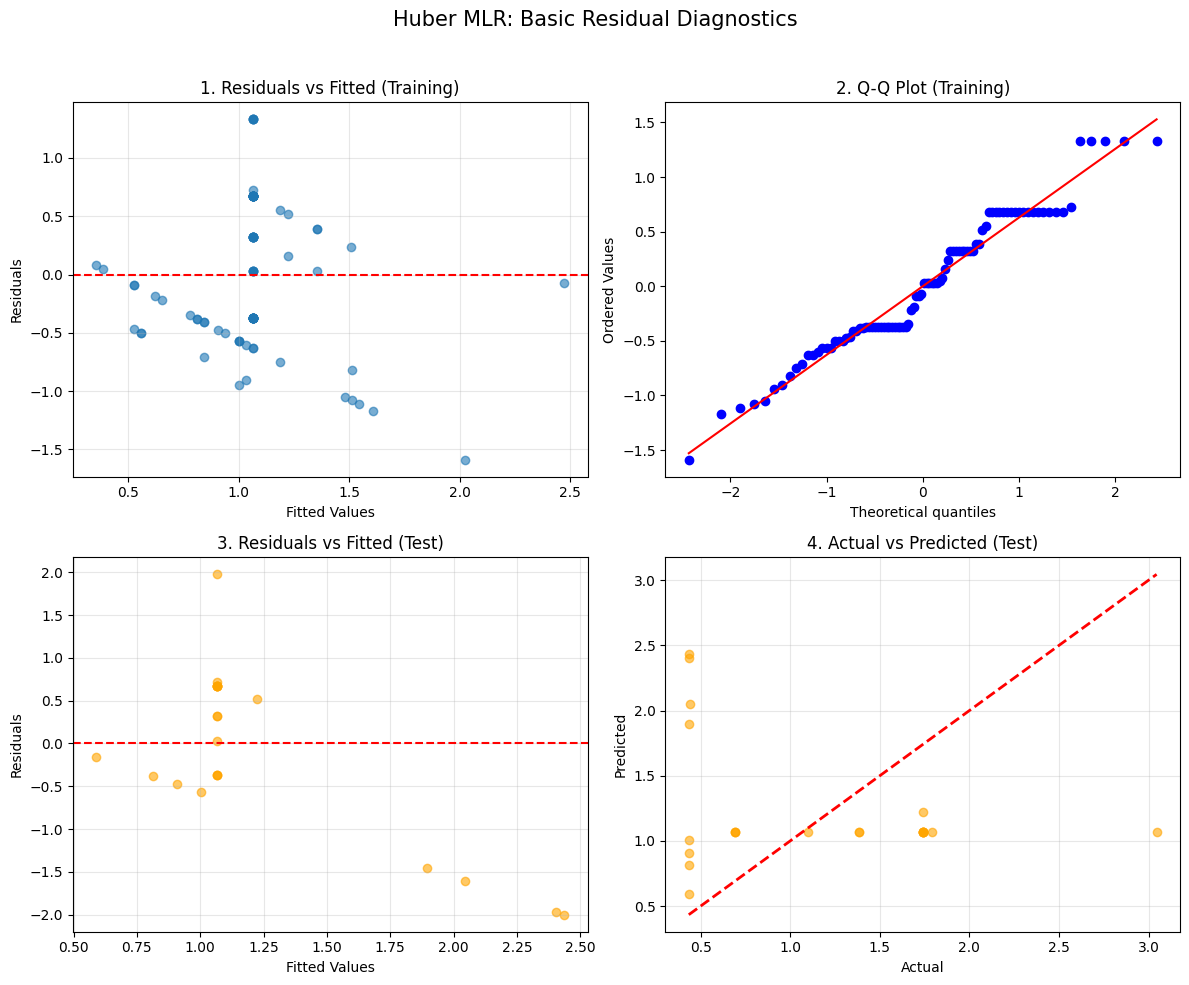


Top coefficients (by |value|):
       feature  coefficient  abs_coefficient
          ilvl    -0.218394         0.218394
       quality     0.152134         0.152134
  socket_count     0.071455         0.071455
open_slots_est     0.029466         0.029466
  is_corrupted    -0.026484         0.026484
Huber MLR PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.8937
Mean Absolute Error: 0.7688
Root Mean Squared Error: 0.9643


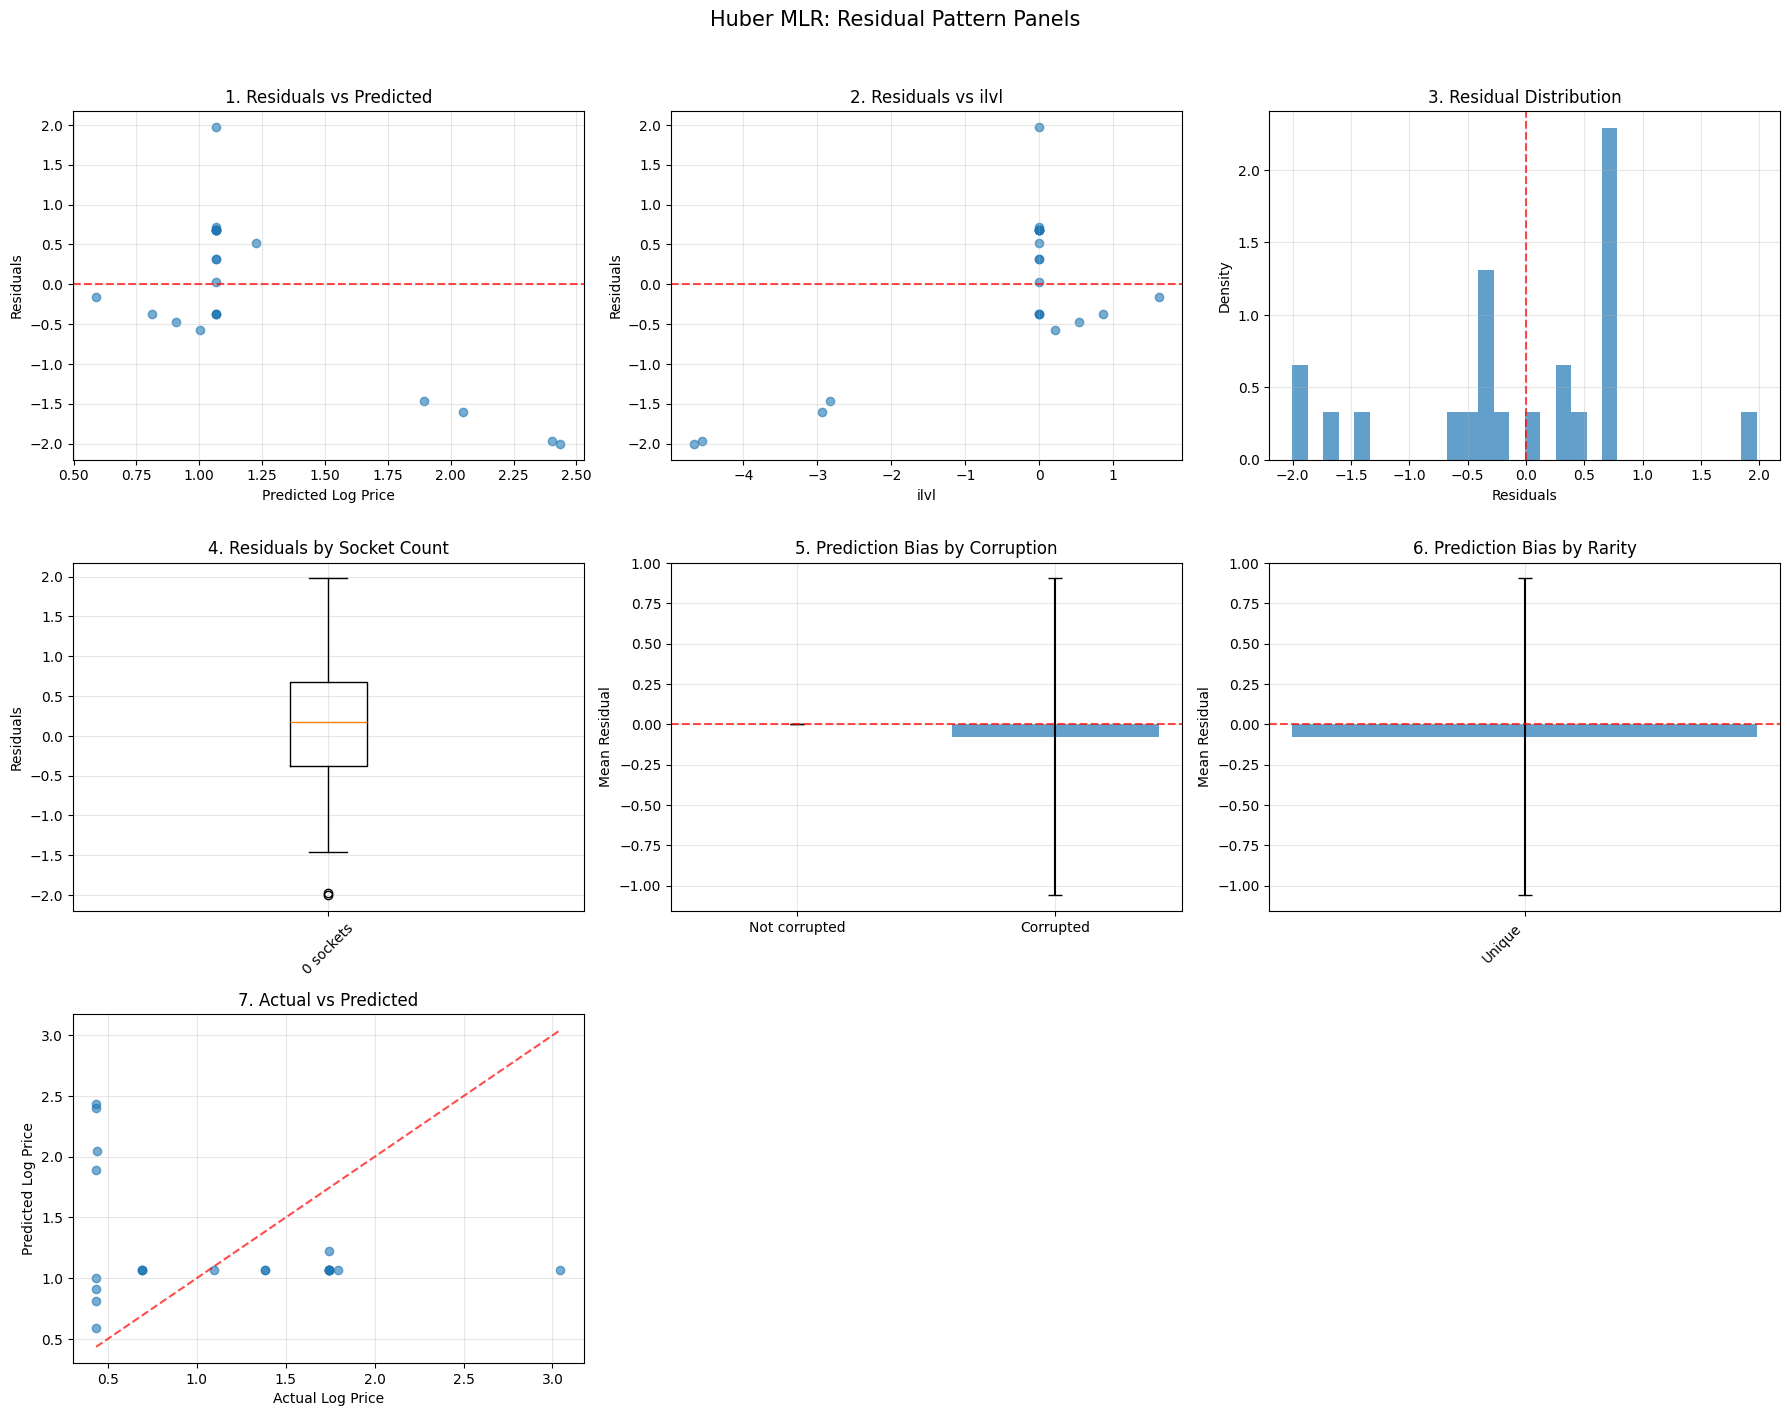

Huber Regression Output for Enezun's Charge:
{'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('huber', HuberRegressor(alpha=0.0, max_iter=5000))]), 'X_train':          ilvl  socket_count   quality  is_corrupted  open_slots_est
446 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439
493 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439
947  0.963697     -0.254588 -0.117625     -0.213201       -0.124439
989 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439
423 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439
..        ...           ...       ...           ...             ...
985 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439
403 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439
945  0.530786     -0.254588 -0.117625     -0.213201       -0.124439
471 -0.010352     -0.254588  3.103069     -0.213201       -0.124439
969 -0.010352     -0.254588 -0.117625     -0.213201       -0.124439



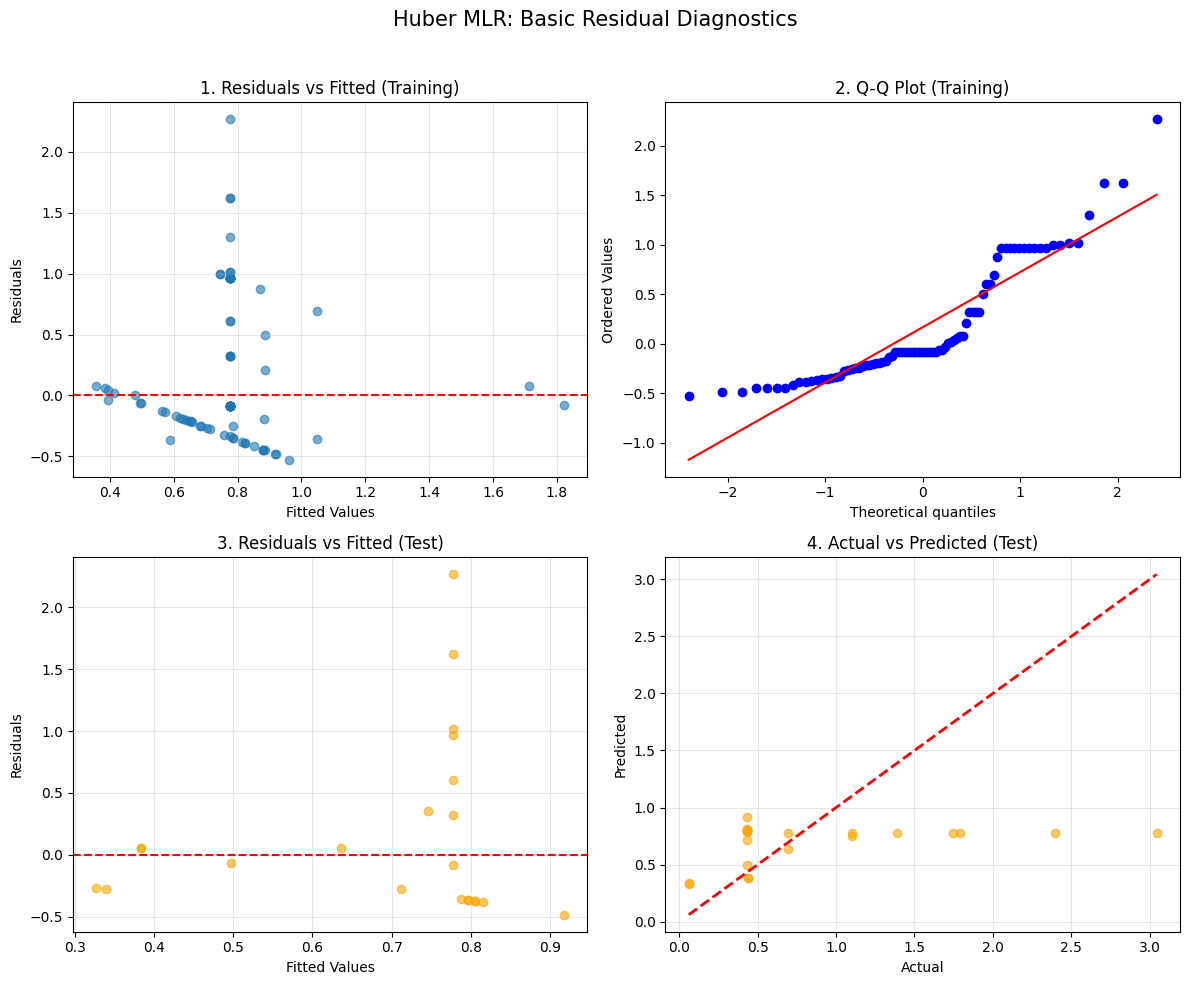


Top coefficients (by |value|):
       feature  coefficient  abs_coefficient
          ilvl     0.108911         0.108911
open_slots_est     0.101077         0.101077
      max_mana    -0.056280         0.056280
       quality     0.048936         0.048936
  socket_count     0.038350         0.038350
Huber MLR PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.0707
Mean Absolute Error: 0.4989
Root Mean Squared Error: 0.7264


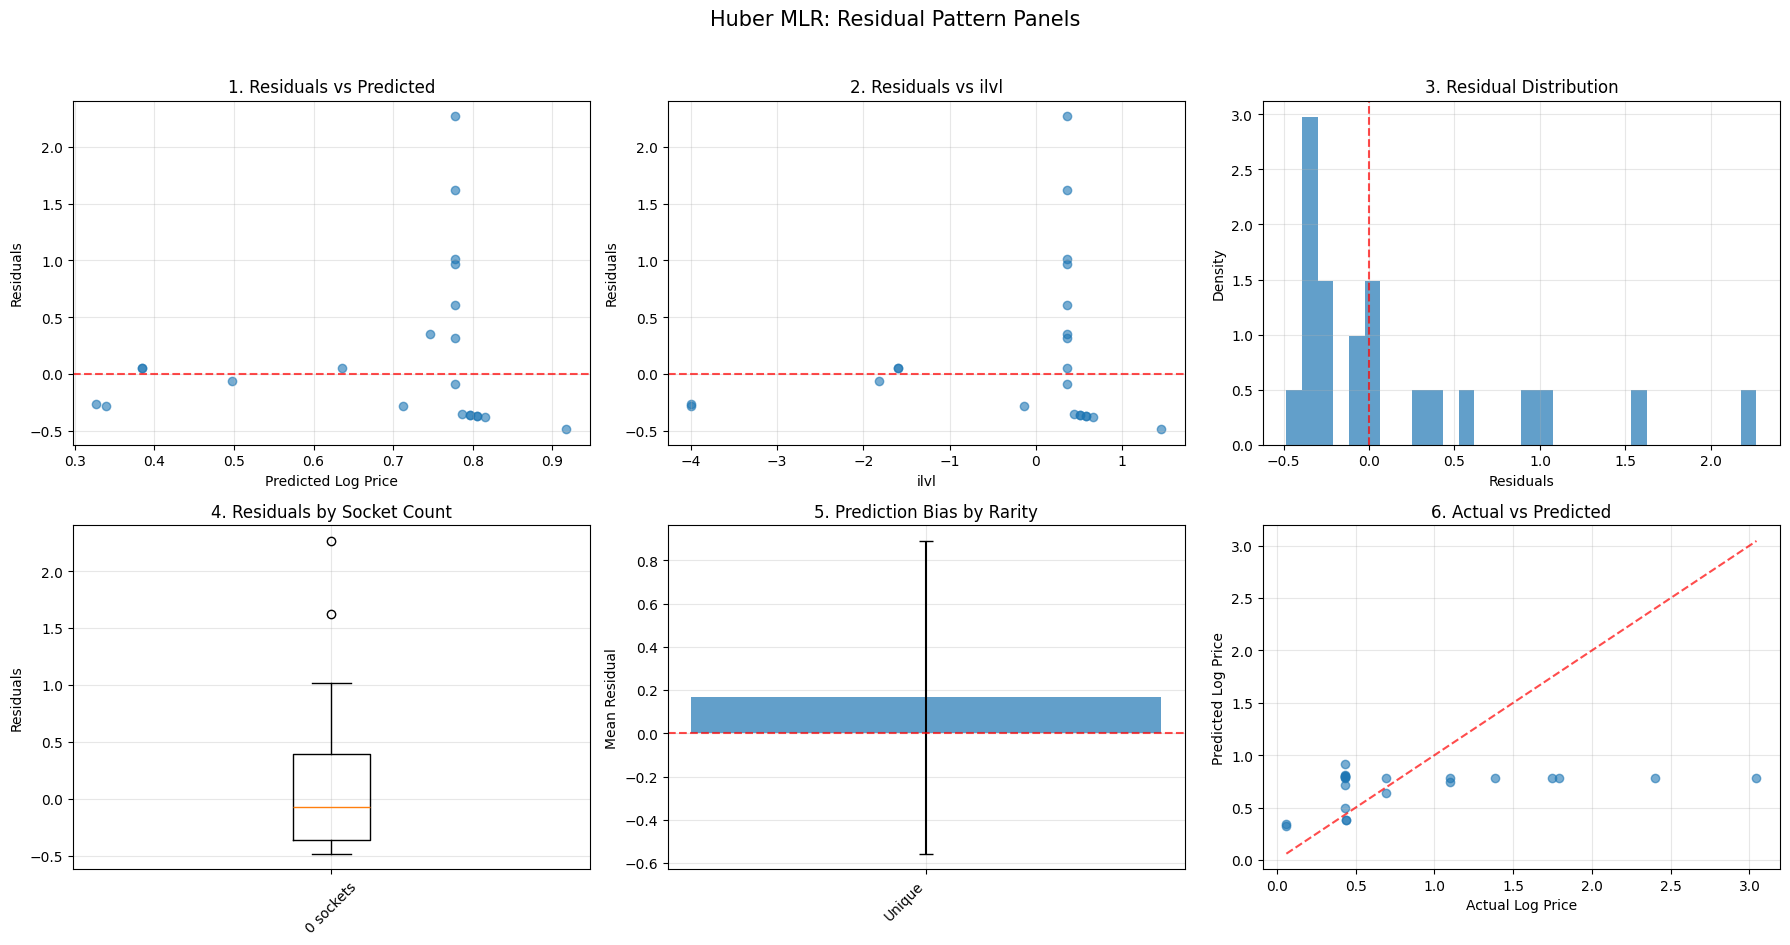

Huber Regression Output for Lifesprig:
{'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('huber', HuberRegressor(alpha=0.0, max_iter=5000))]), 'X_train':          ilvl  socket_count   quality  max_mana  open_slots_est
620  0.509861     -0.390095 -0.209881  0.138675       -1.409547
402  0.364578     -0.390095 -0.209881  0.138675        0.099665
381 -0.725045     -0.390095 -0.209881  0.138675        0.099665
418  0.364578     -0.390095 -0.209881  0.138675        0.099665
441  0.364578     -0.390095 -0.209881  0.138675        0.099665
..        ...           ...       ...       ...             ...
914  0.437220     -0.390095 -0.209881  0.138675        0.099665
359  0.727786     -0.390095 -0.209881  0.138675       -1.409547
974  0.364578     -0.390095 -0.209881 -7.211103        6.136514
470  0.364578     -0.390095 -0.209881  0.138675        0.099665
997  0.364578     -0.390095 -0.209881  0.138675        0.099665

[84 rows x 5 columns], 'X_test':          ilvl  socket

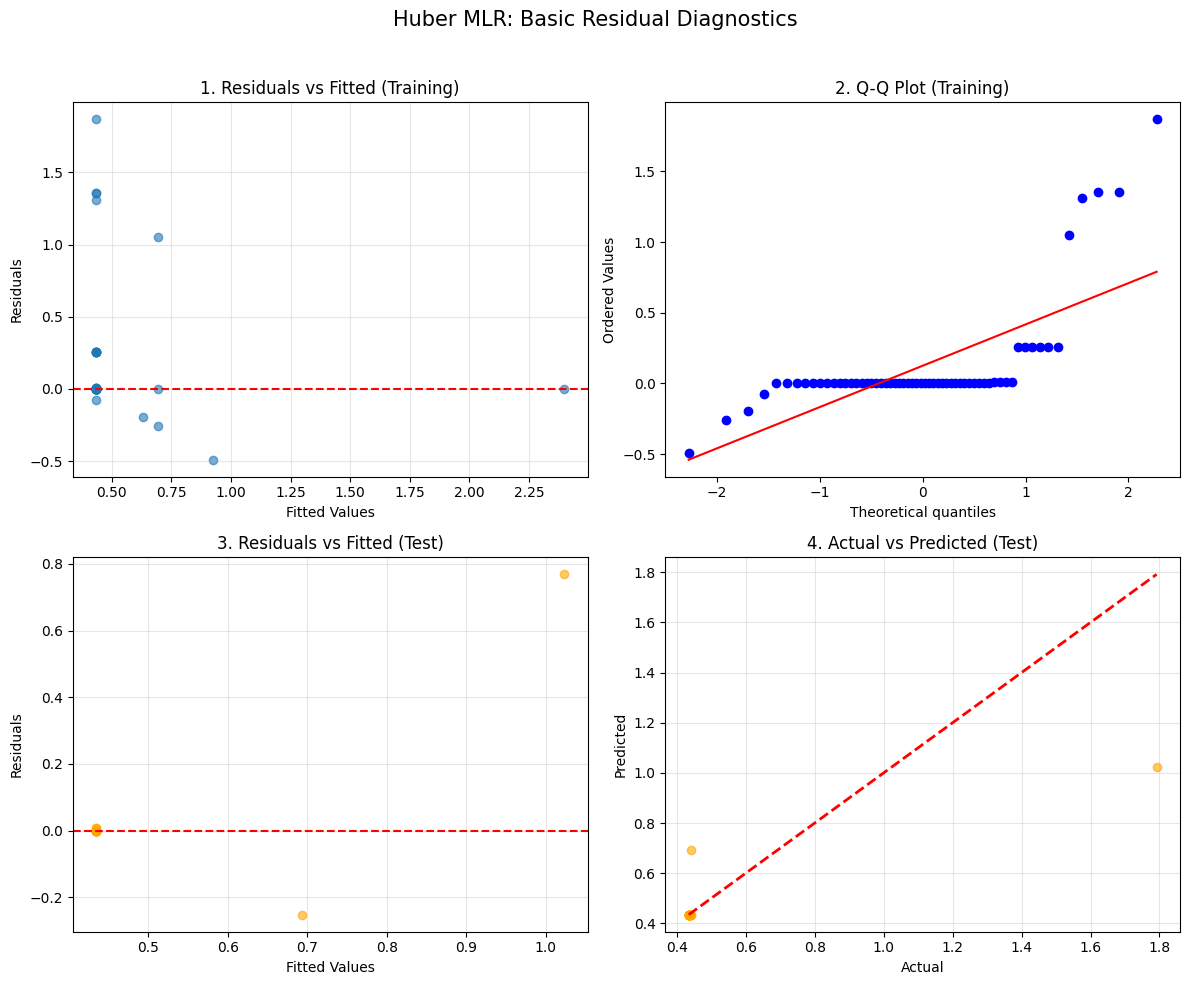


Top coefficients (by |value|):
         feature   coefficient  abs_coefficient
         quality  2.587844e-01     2.587844e-01
attack_speed_pct -5.641634e-02     5.641634e-02
  open_slots_est -5.612822e-08     5.612822e-08
    socket_count -1.036584e-08     1.036584e-08
            ilvl  7.178154e-09     7.178154e-09
Huber MLR PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.6207
Mean Absolute Error: 0.0646
Root Mean Squared Error: 0.2022


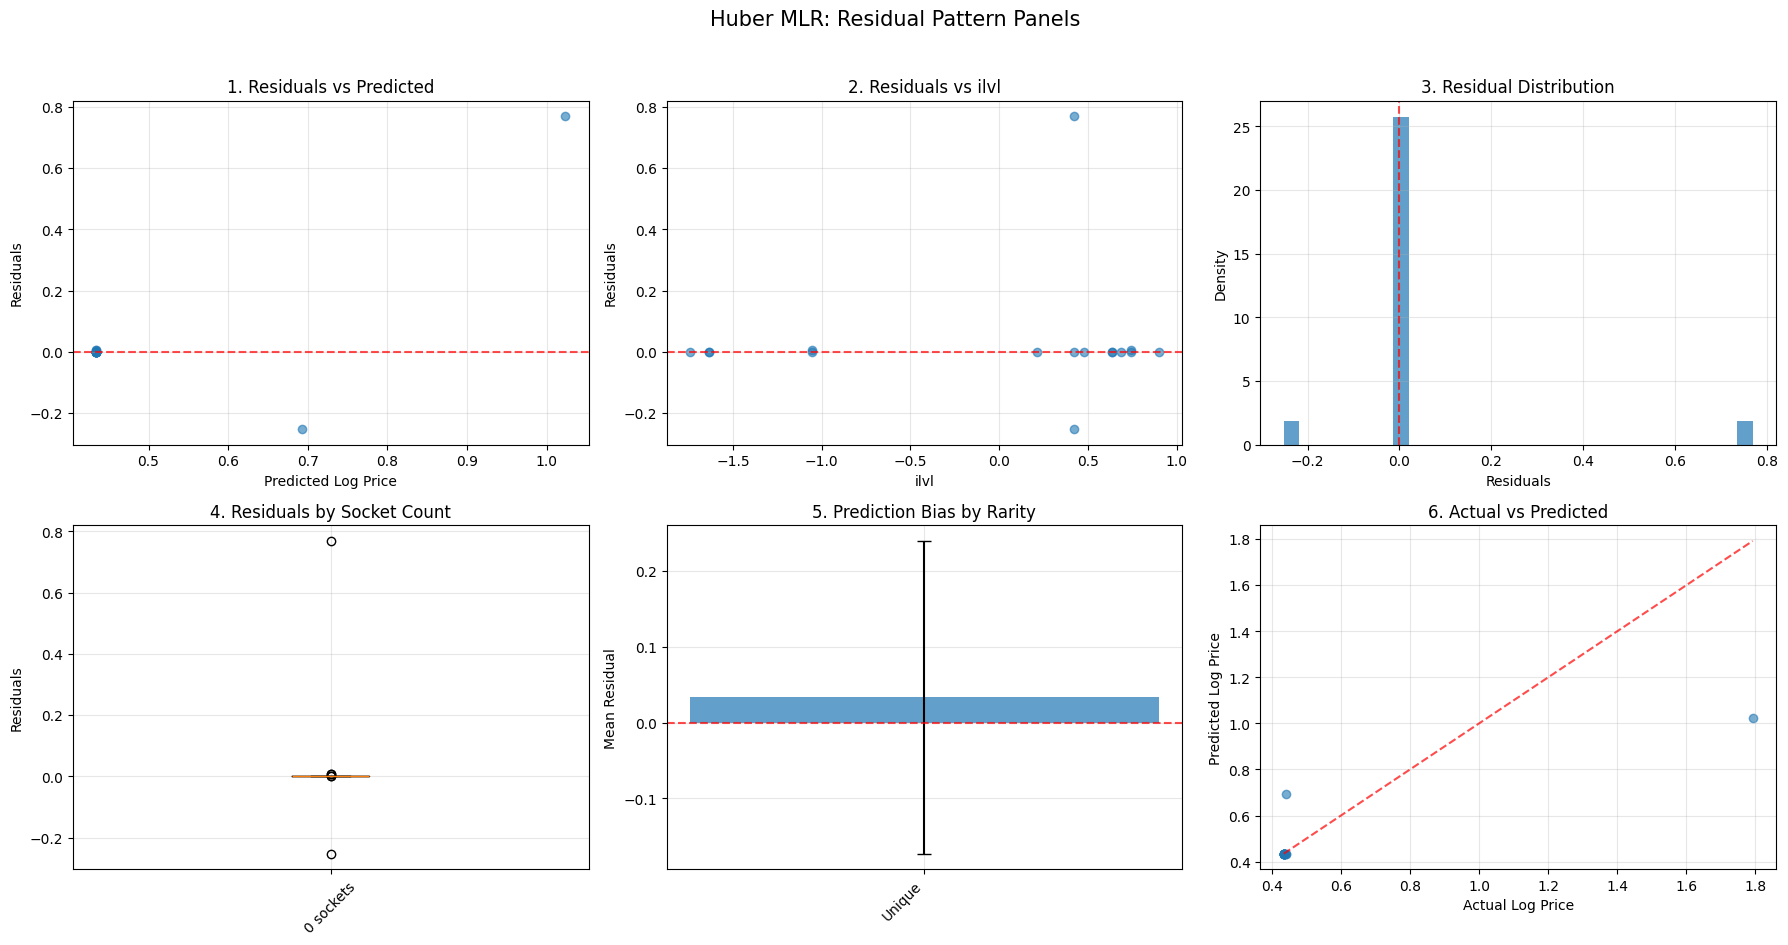

Huber Regression Output for Sanguine Diviner:
{'model': Pipeline(steps=[('scaler', StandardScaler()),
                ('huber', HuberRegressor(alpha=0.0, max_iter=5000))]), 'X_train':          ilvl  socket_count   quality  attack_speed_pct  open_slots_est
324 -0.103623     -0.366508 -0.178311          0.235702       -0.012907
318 -1.636408     -0.366508 -0.178311          0.235702       -0.012907
388 -1.636408     -0.366508 -0.178311          0.235702       -0.012907
354 -1.319280     -0.366508 -0.178311          0.235702       -0.012907
378 -1.953536     -0.366508 -0.178311          0.235702       -0.012907
415  0.424924     -0.366508 -0.178311          0.235702       -0.012907
412  0.424924     -0.366508 -0.178311          0.235702       -0.012907
340  0.002086     -0.366508 -0.178311          0.235702       -0.012907
939  0.847761     -0.366508 -0.178311          0.235702       -0.012907
713  0.424924     -0.366508 -0.178311          0.235702       -0.012907
384 -1.002152     -0.366

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.

In [ ]:
from modelling import run_huber

# Iterate over each unique item in the dictionary
for name, data in unique_item_features.items():
    X_unique = data["features"]
    y_unique = data["target"]
    
    # Run the Huber regression model for the current unique item
    out_huber = run_huber(X_unique, y_unique["log_price"], metadata=data["metadata"], cv_splits=5, test_size=0.2, random_state=42)
    
    # Output the results for each unique item
    print(f"Huber Regression Output for {name}:")
    print(out_huber)



=== Huber+Ridge (grid search, Pipeline) ===
Best params: {'huber__alpha': np.float64(10.0)} | CV R² mean=0.0441 ± 0.0833
r2_train: 0.1397
r2_test: 0.1274
rmse_test: 0.1624
mae_test: 0.1471

Top coefficients (|value|):
                  feature  coefficient  abs_coefficient
                  req_int    -0.078807         0.078807
       explicit_mod_count     0.071675         0.071675
highest_explicit_tier_num    -0.046491         0.046491
             socket_count     0.031148         0.031148
                     ilvl     0.028734         0.028734
     other_mods_avg_level    -0.024900         0.024900
                req_level     0.018380         0.018380
         attack_speed_pct    -0.017621         0.017621
         other_mods_count     0.013696         0.013696
                  quality     0.013372         0.013372
     reduced_requirements     0.010364         0.010364
     other_mods_avg_value     0.007614         0.007614
             light_radius    -0.006951         0.0069

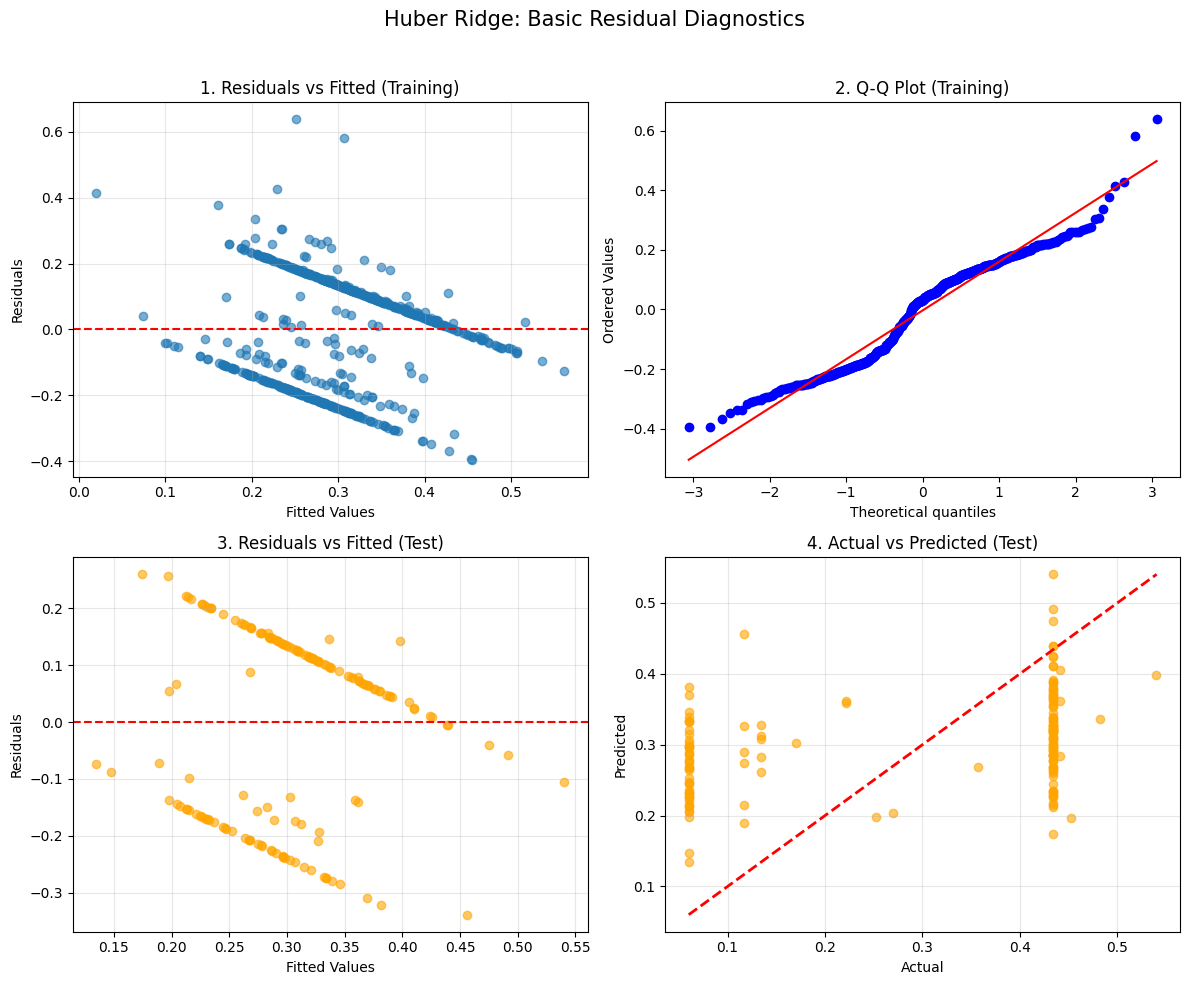

Huber Ridge PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.1274
Mean Absolute Error: 0.1471
Root Mean Squared Error: 0.1624


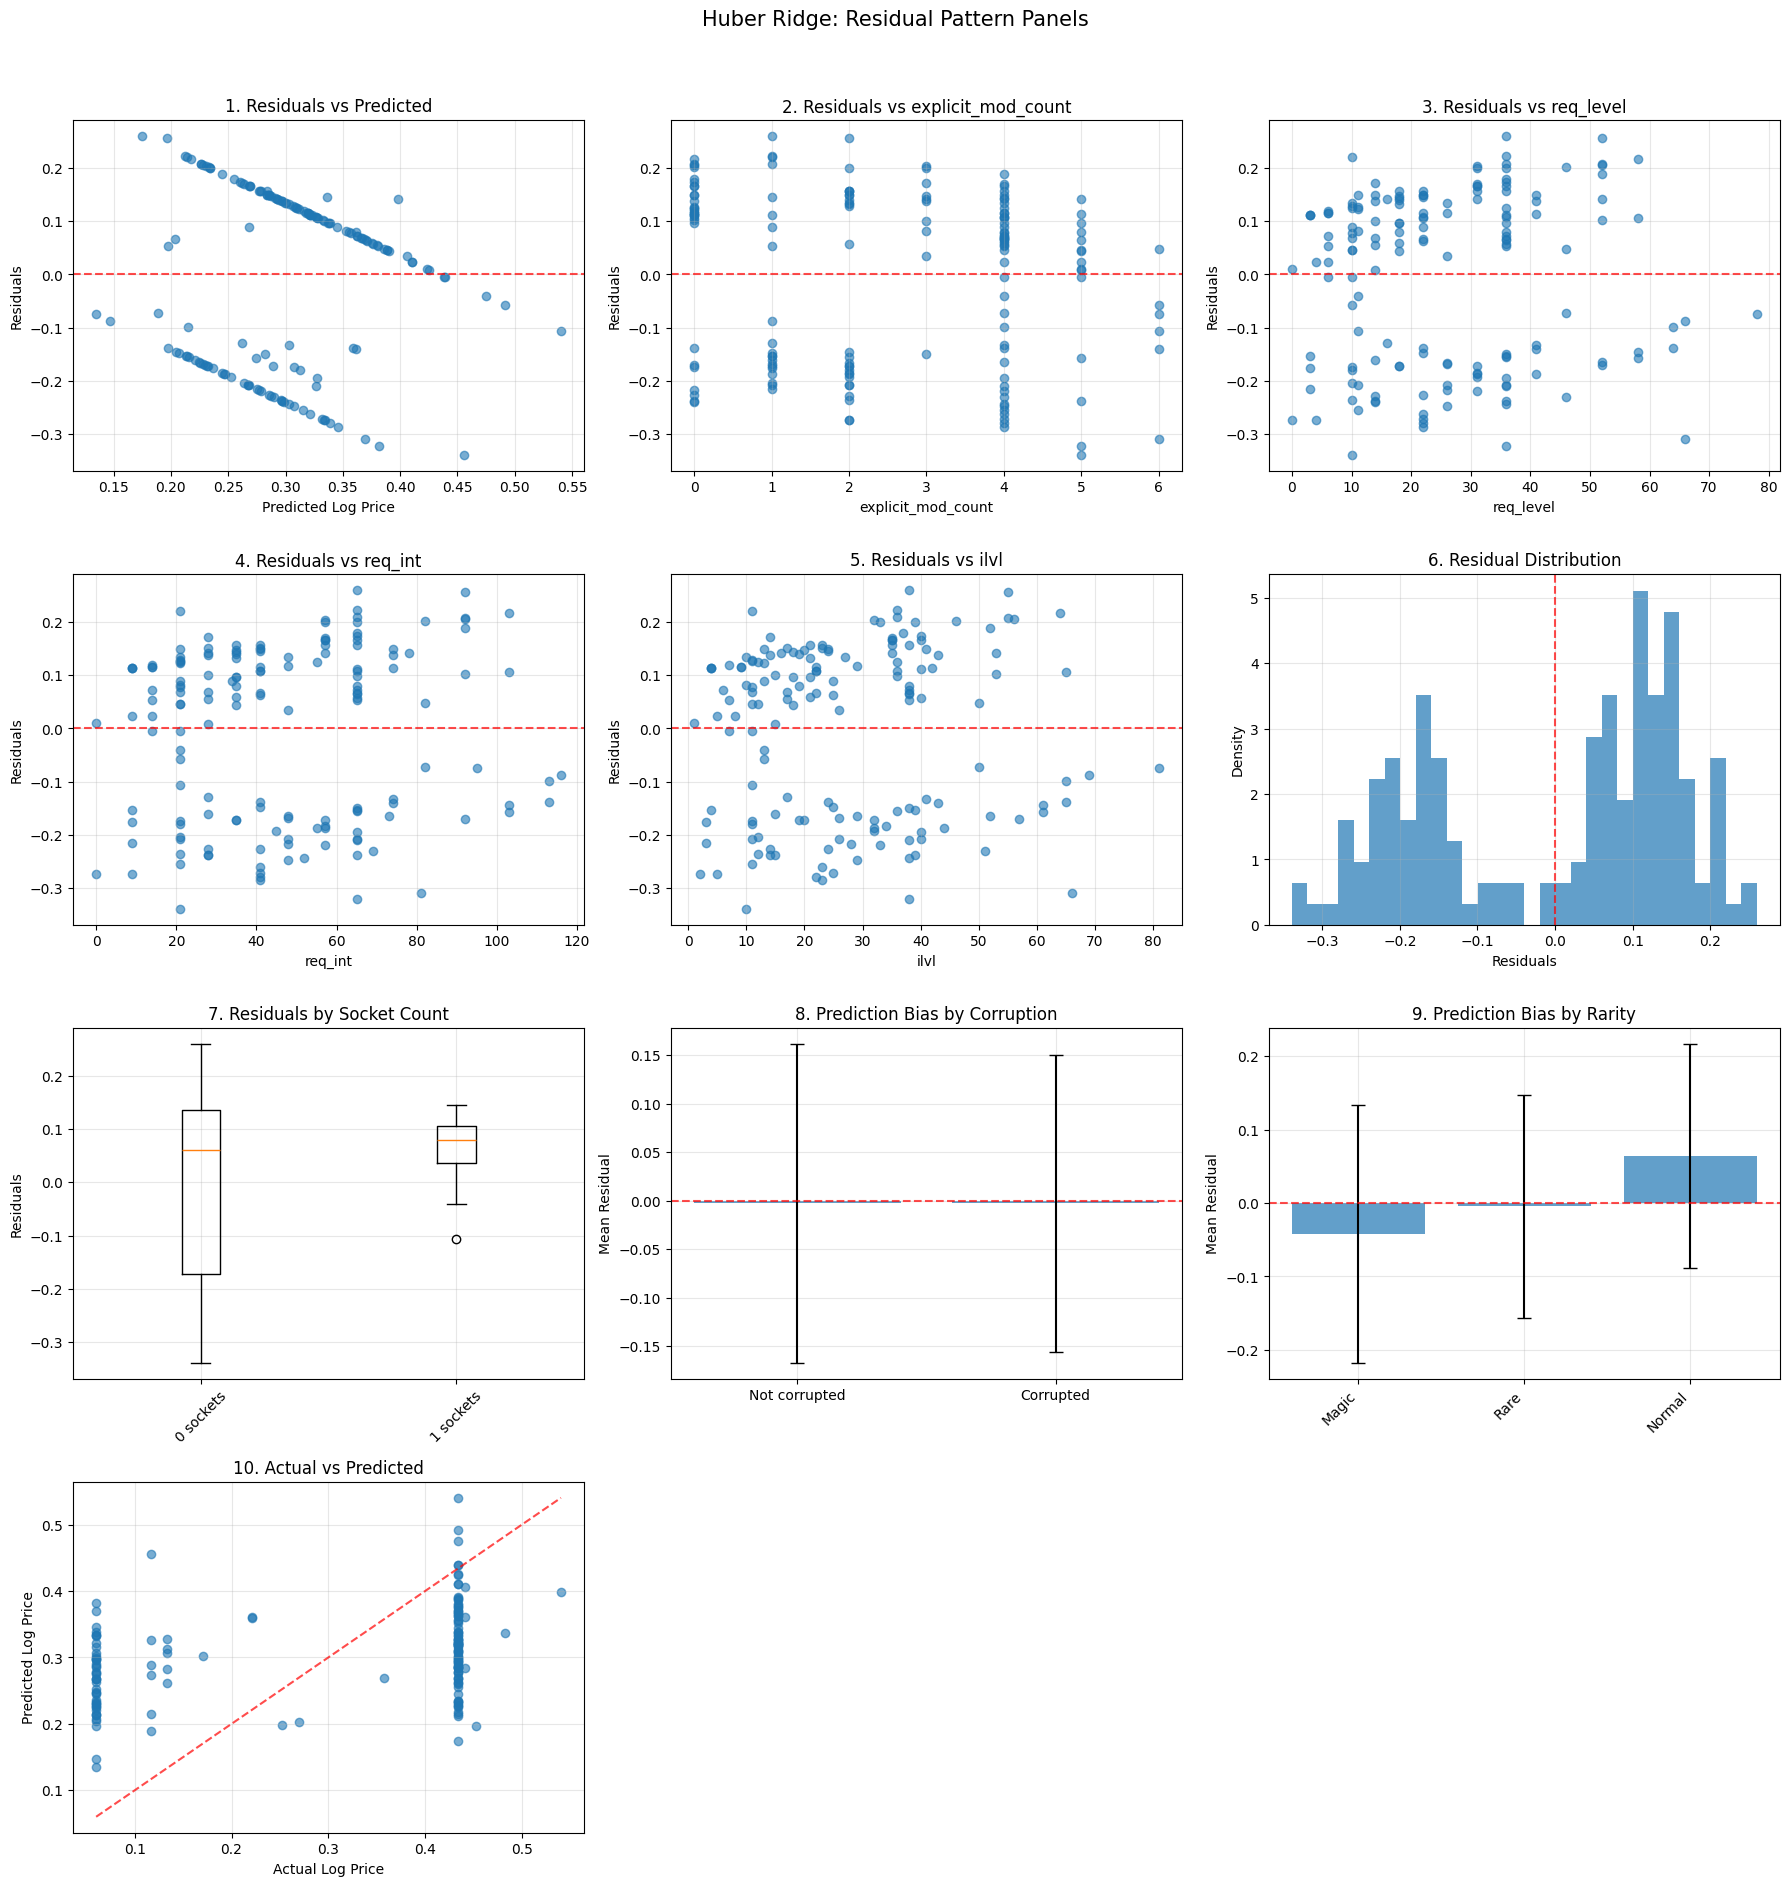


=== Huber+ElasticNet (grid search, Pipeline) ===
Best params: {'sgd__alpha': np.float64(0.003593813663804626), 'sgd__l1_ratio': 0.85} | CV R² mean=0.0379 ± 0.0632
r2_train: 0.0437
r2_test: 0.0393
rmse_test: 0.1704
mae_test: 0.1613

Non-zero coefficients: 2/17

Top coefficients (|value|):
                  feature  coefficient  abs_coefficient
             socket_count     0.041372         0.041372
highest_explicit_tier_num    -0.009577         0.009577
                     ilvl     0.000000         0.000000
     reduced_requirements     0.000000         0.000000
         attack_speed_pct     0.000000         0.000000
             light_radius     0.000000         0.000000
                 max_mana     0.000000         0.000000
             is_corrupted     0.000000         0.000000
   highest_explicit_level     0.000000         0.000000
         other_mods_count     0.000000         0.000000
     other_mods_avg_level     0.000000         0.000000
     other_mods_avg_value     0.000000

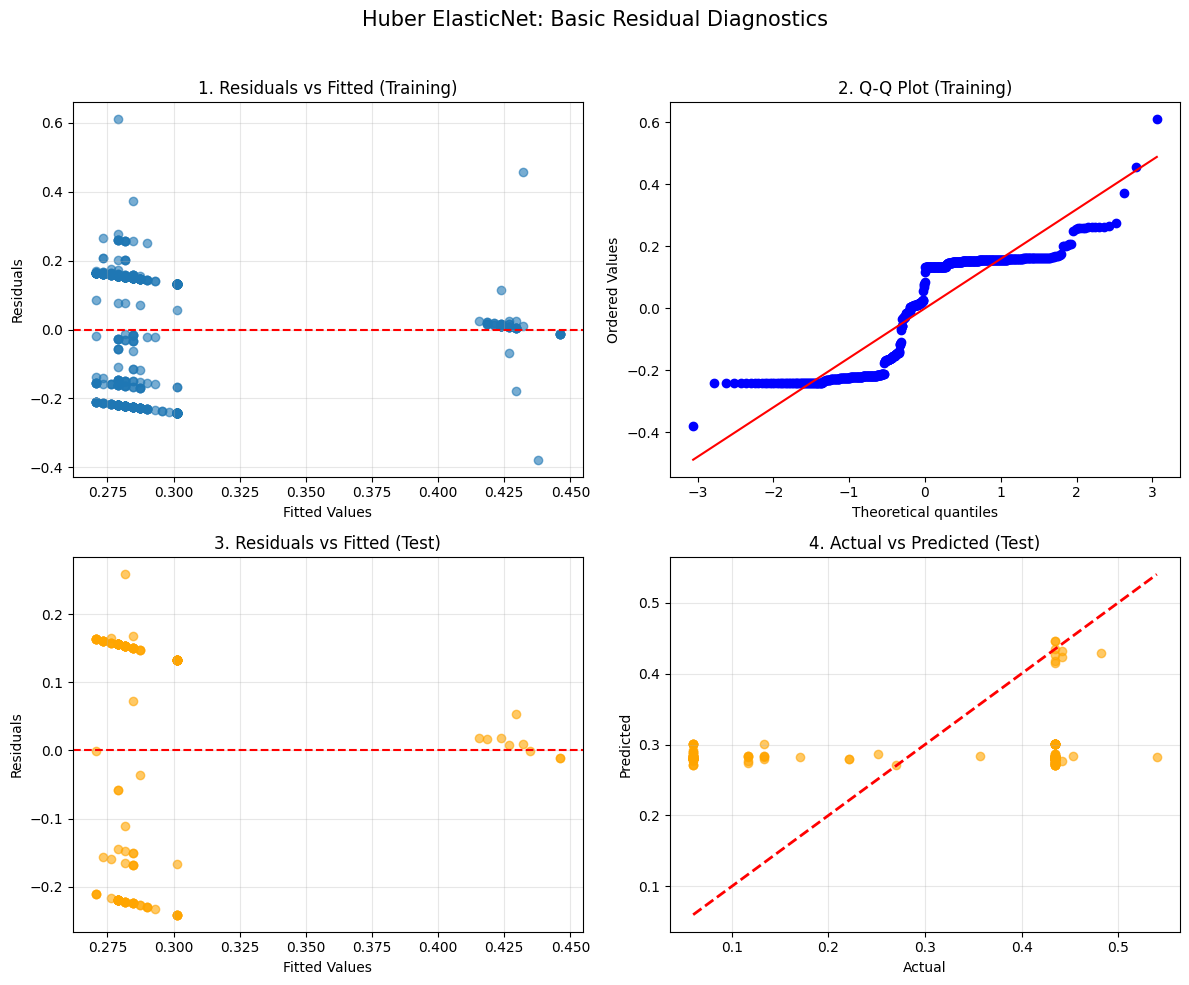

Huber ElasticNet PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.0393
Mean Absolute Error: 0.1613
Root Mean Squared Error: 0.1704


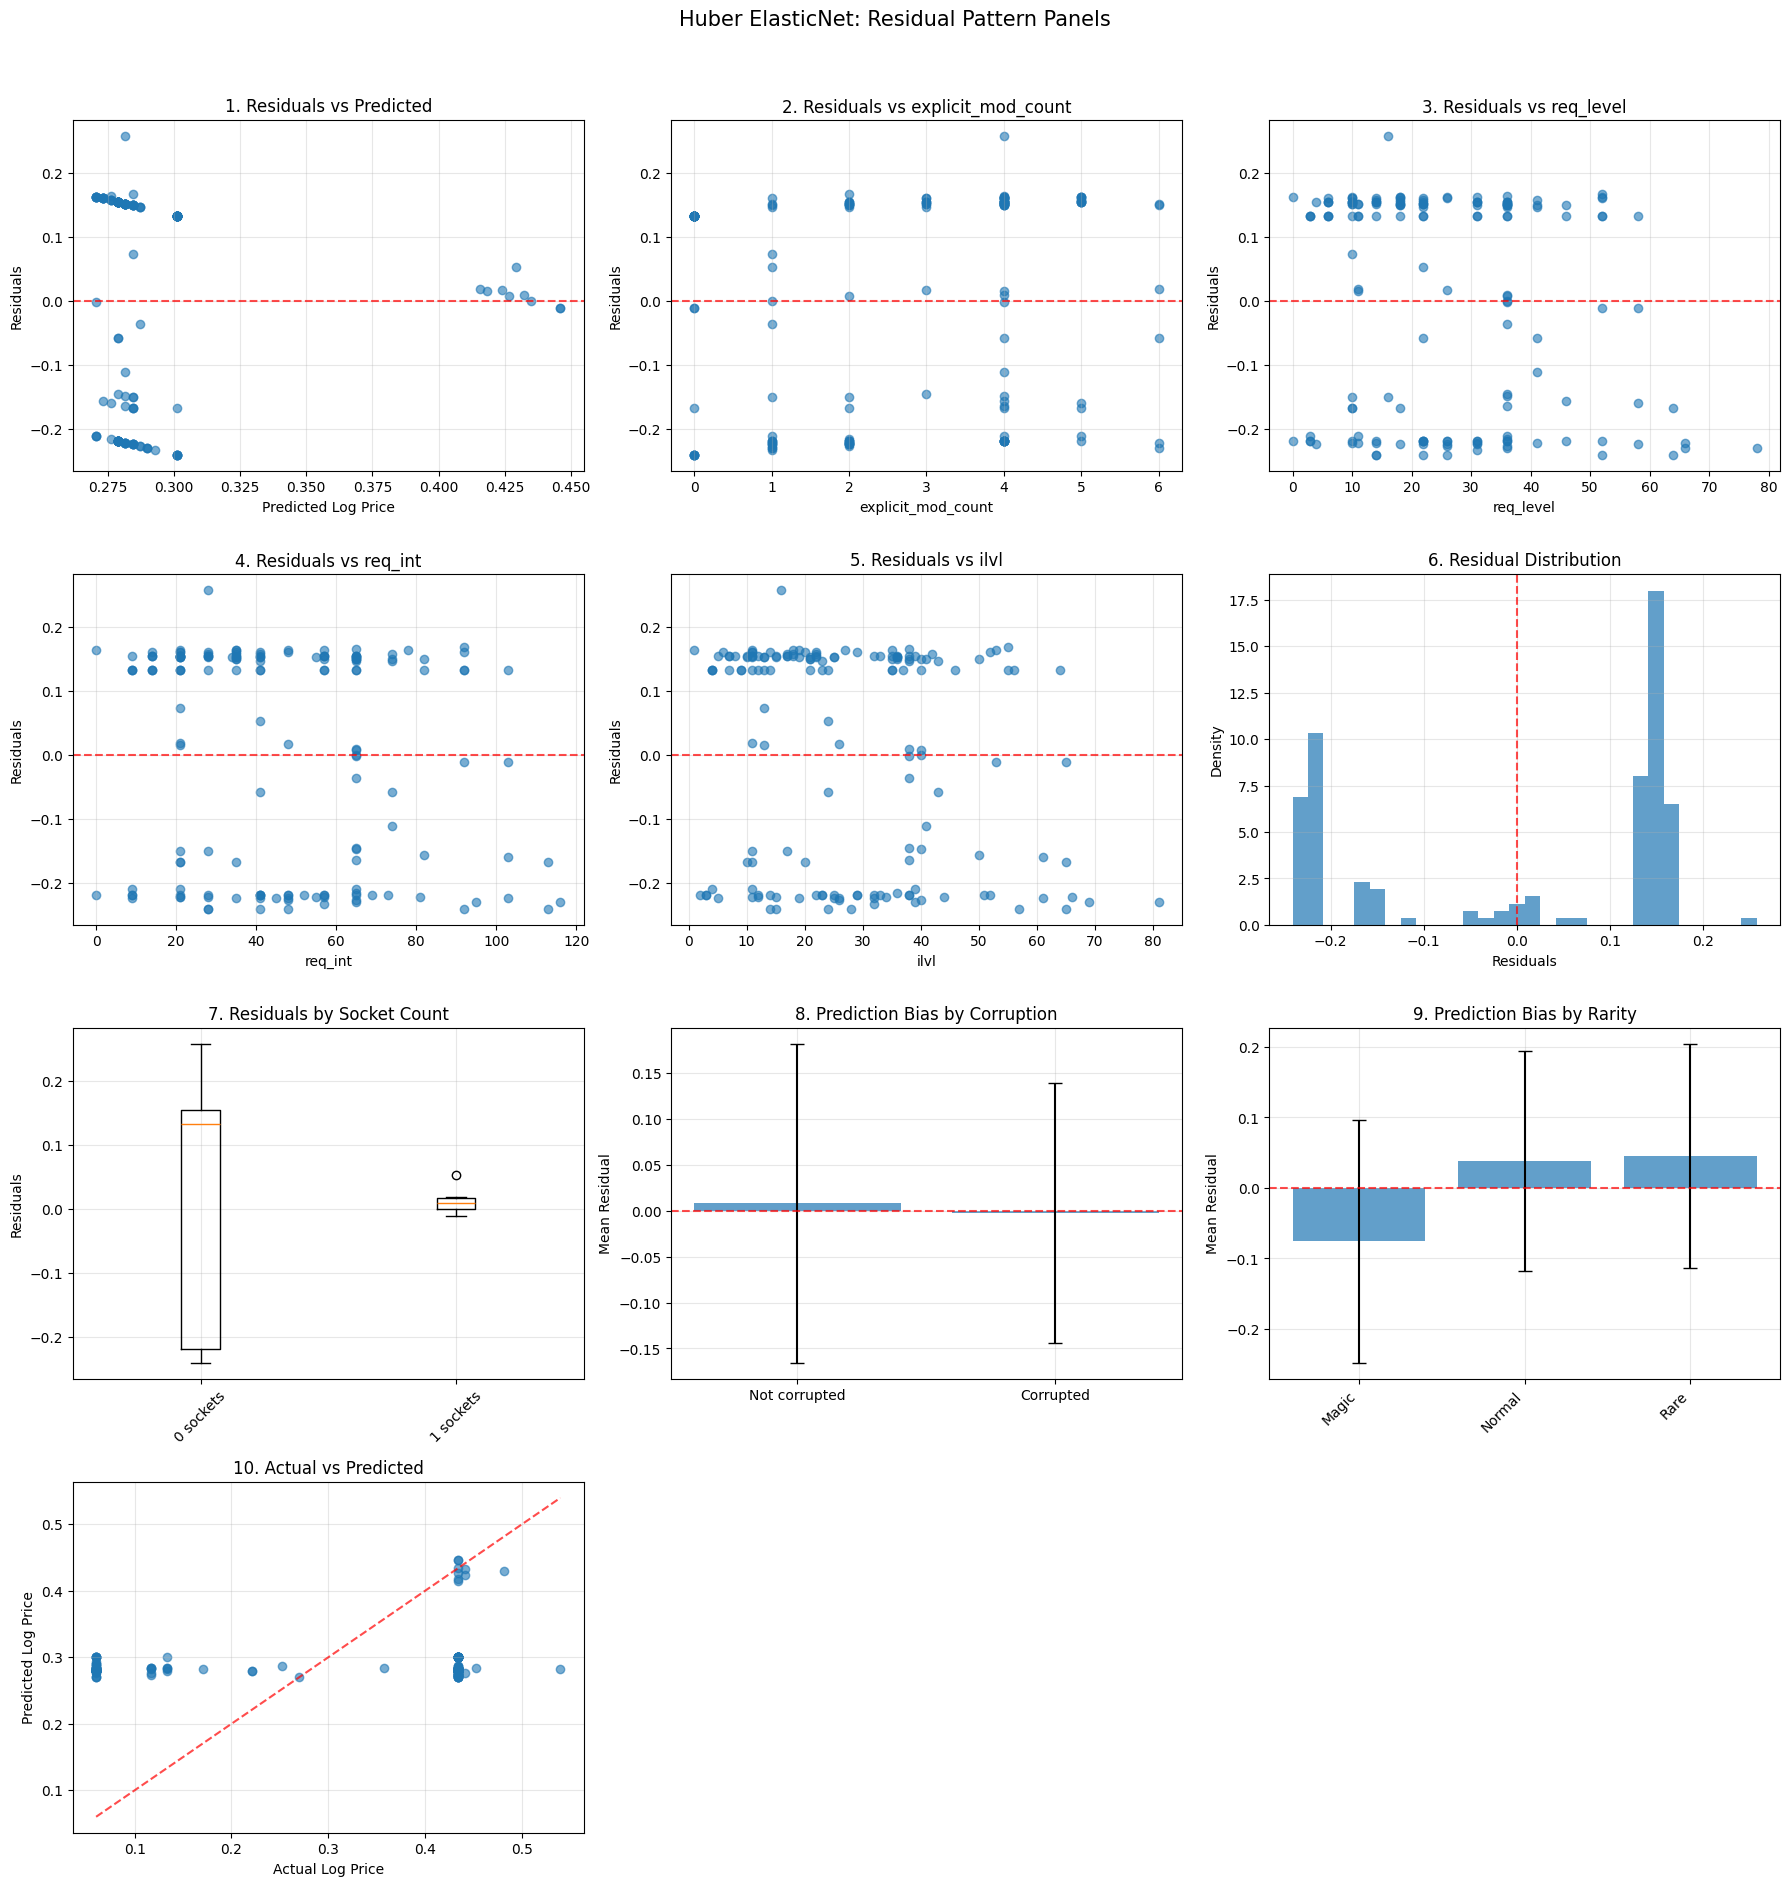


=== Regularized Models (Huber, Pipelines): Comparison ===
          model  best_alpha  best_l1_ratio  cv_mean_r2  cv_std_r2  test_r2  test_rmse  test_mae
     HuberRidge     10.0000            NaN      0.0441     0.0833   0.1274     0.1624    0.1471
HuberElasticNet      0.0036         0.8500      0.0379     0.0632   0.0393     0.1704    0.1613
Comparison of Regularized Models for Craftables:
{'Ridge': {'name': 'HuberRidge', 'grid_search': GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('huber',
                                        HuberRegressor(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'huber__alpha': [np.float64(1e-06),
                                          np.float64(2.580861540418077e-06),
                                          np.float64(6.660846290809154e-06),
                                          np.float64(1.7190

In [ ]:
from modelling import compare_regularized_models
import numpy as np

# Compare regularized models for craftables
cmp = compare_regularized_models(
    Xc, yc["log_price"], metadata=mc,
    ridge_alphas=np.logspace(-6, 1, 18),
    en_alphas=np.logspace(-6, -2, 10),
    en_l1_ratios=[0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95],
    cv_splits=5, test_size=0.2, random_state=42, n_jobs=-1, epsilon=1.35, plots=True
)

# Output the comparison results
print("Comparison of Regularized Models for Craftables:")
print(cmp)


Comparison of Regularized Models for Cursecarver:

=== Huber+Ridge (grid search, Pipeline) ===
Best params: {'huber__alpha': np.float64(0.005080218046913018)} | CV R² mean=0.5500 ± 0.5568
r2_train: 0.7024
r2_test: 1.0000
rmse_test: 0.0000
mae_test: 0.0000

Top coefficients (|value|):
       feature   coefficient  abs_coefficient
  is_corrupted  2.803194e-03     2.803194e-03
open_slots_est -3.517269e-10     3.517269e-10
          ilvl -2.824495e-10     2.824495e-10
  socket_count -9.793049e-11     9.793049e-11


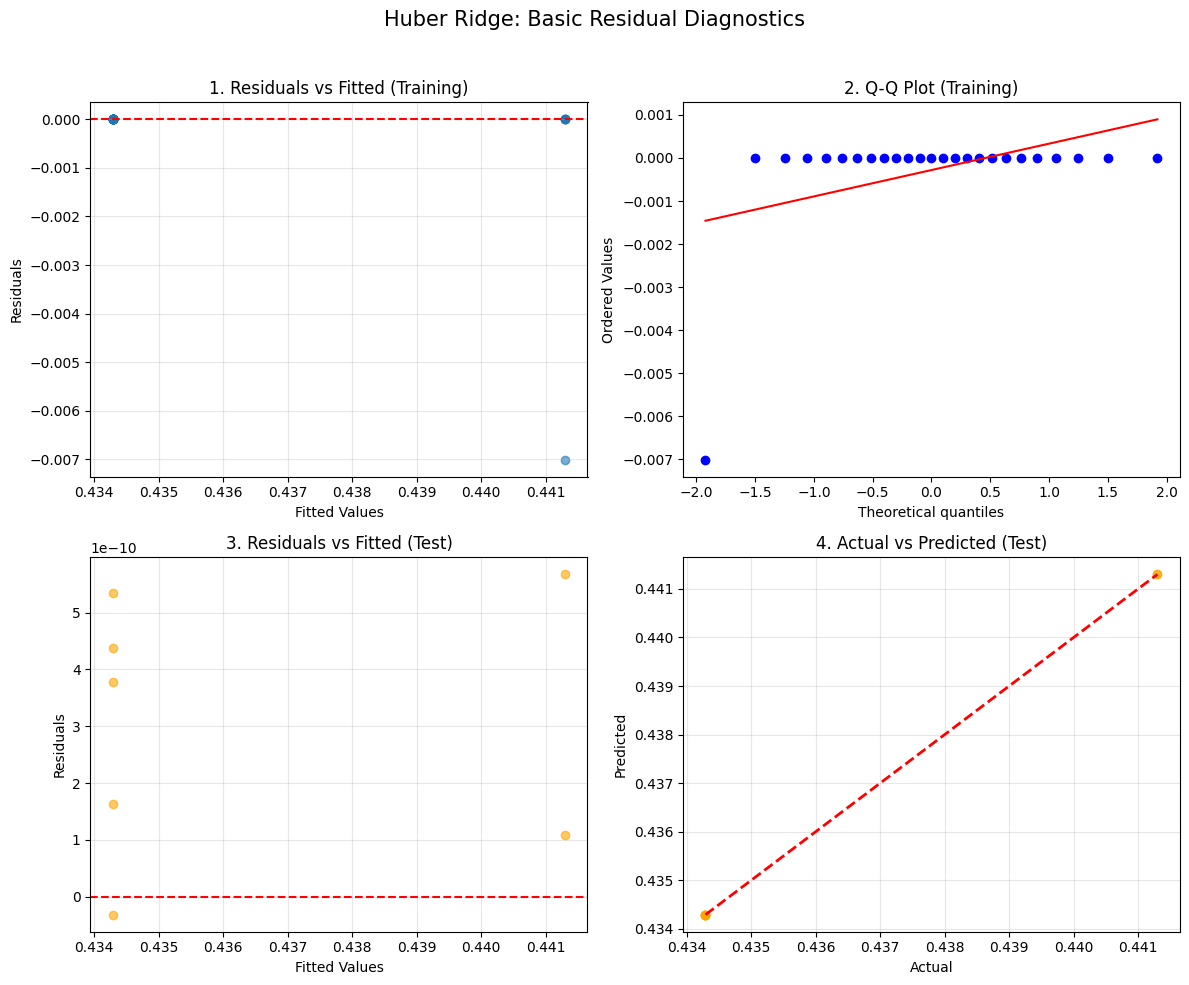

Huber Ridge PERFORMANCE DIAGNOSTICS
Overall Test R²: 1.0000
Mean Absolute Error: 0.0000
Root Mean Squared Error: 0.0000


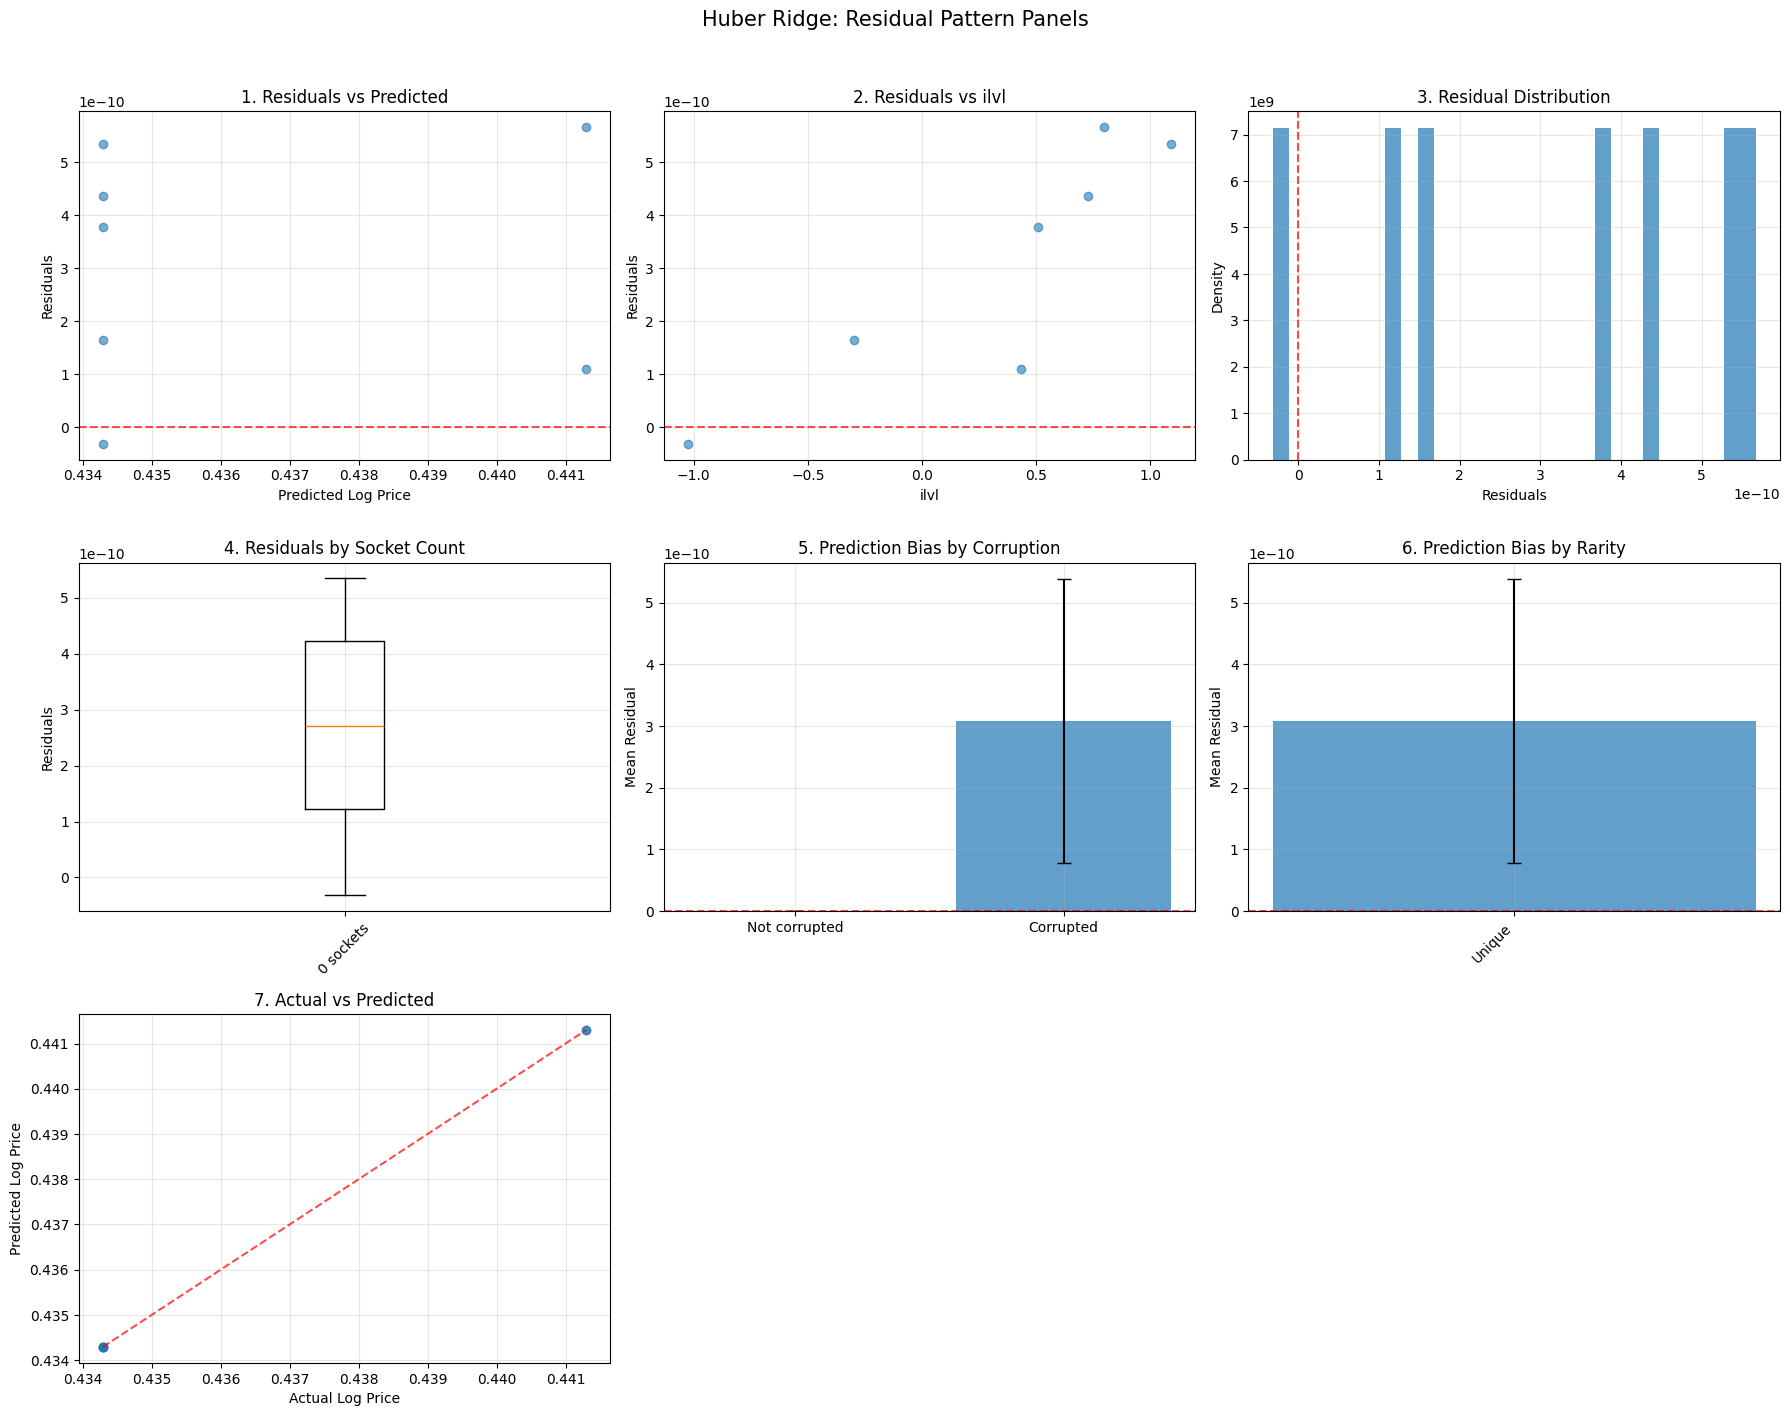


=== Huber+ElasticNet (grid search, Pipeline) ===
Best params: {'sgd__alpha': np.float64(0.01), 'sgd__l1_ratio': 0.15} | CV R² mean=-0.0634 ± 0.0991
r2_train: -0.0974
r2_test: -0.2825
rmse_test: 0.0036
mae_test: 0.0021

Non-zero coefficients: 0/4

Top coefficients (|value|):
       feature  coefficient  abs_coefficient
          ilvl          0.0              0.0
  socket_count          0.0              0.0
  is_corrupted          0.0              0.0
open_slots_est          0.0              0.0


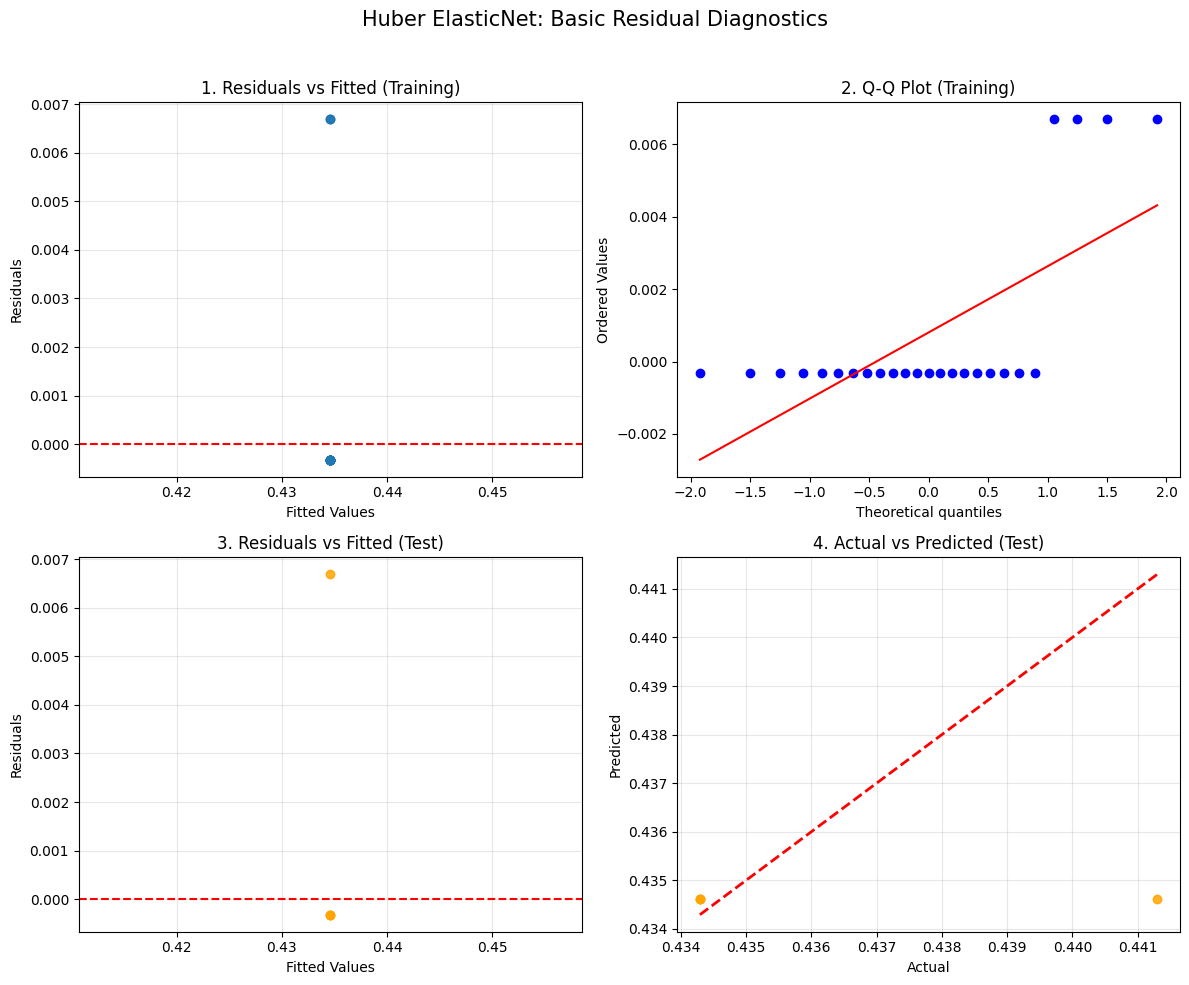

Huber ElasticNet PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.2825
Mean Absolute Error: 0.0021
Root Mean Squared Error: 0.0036


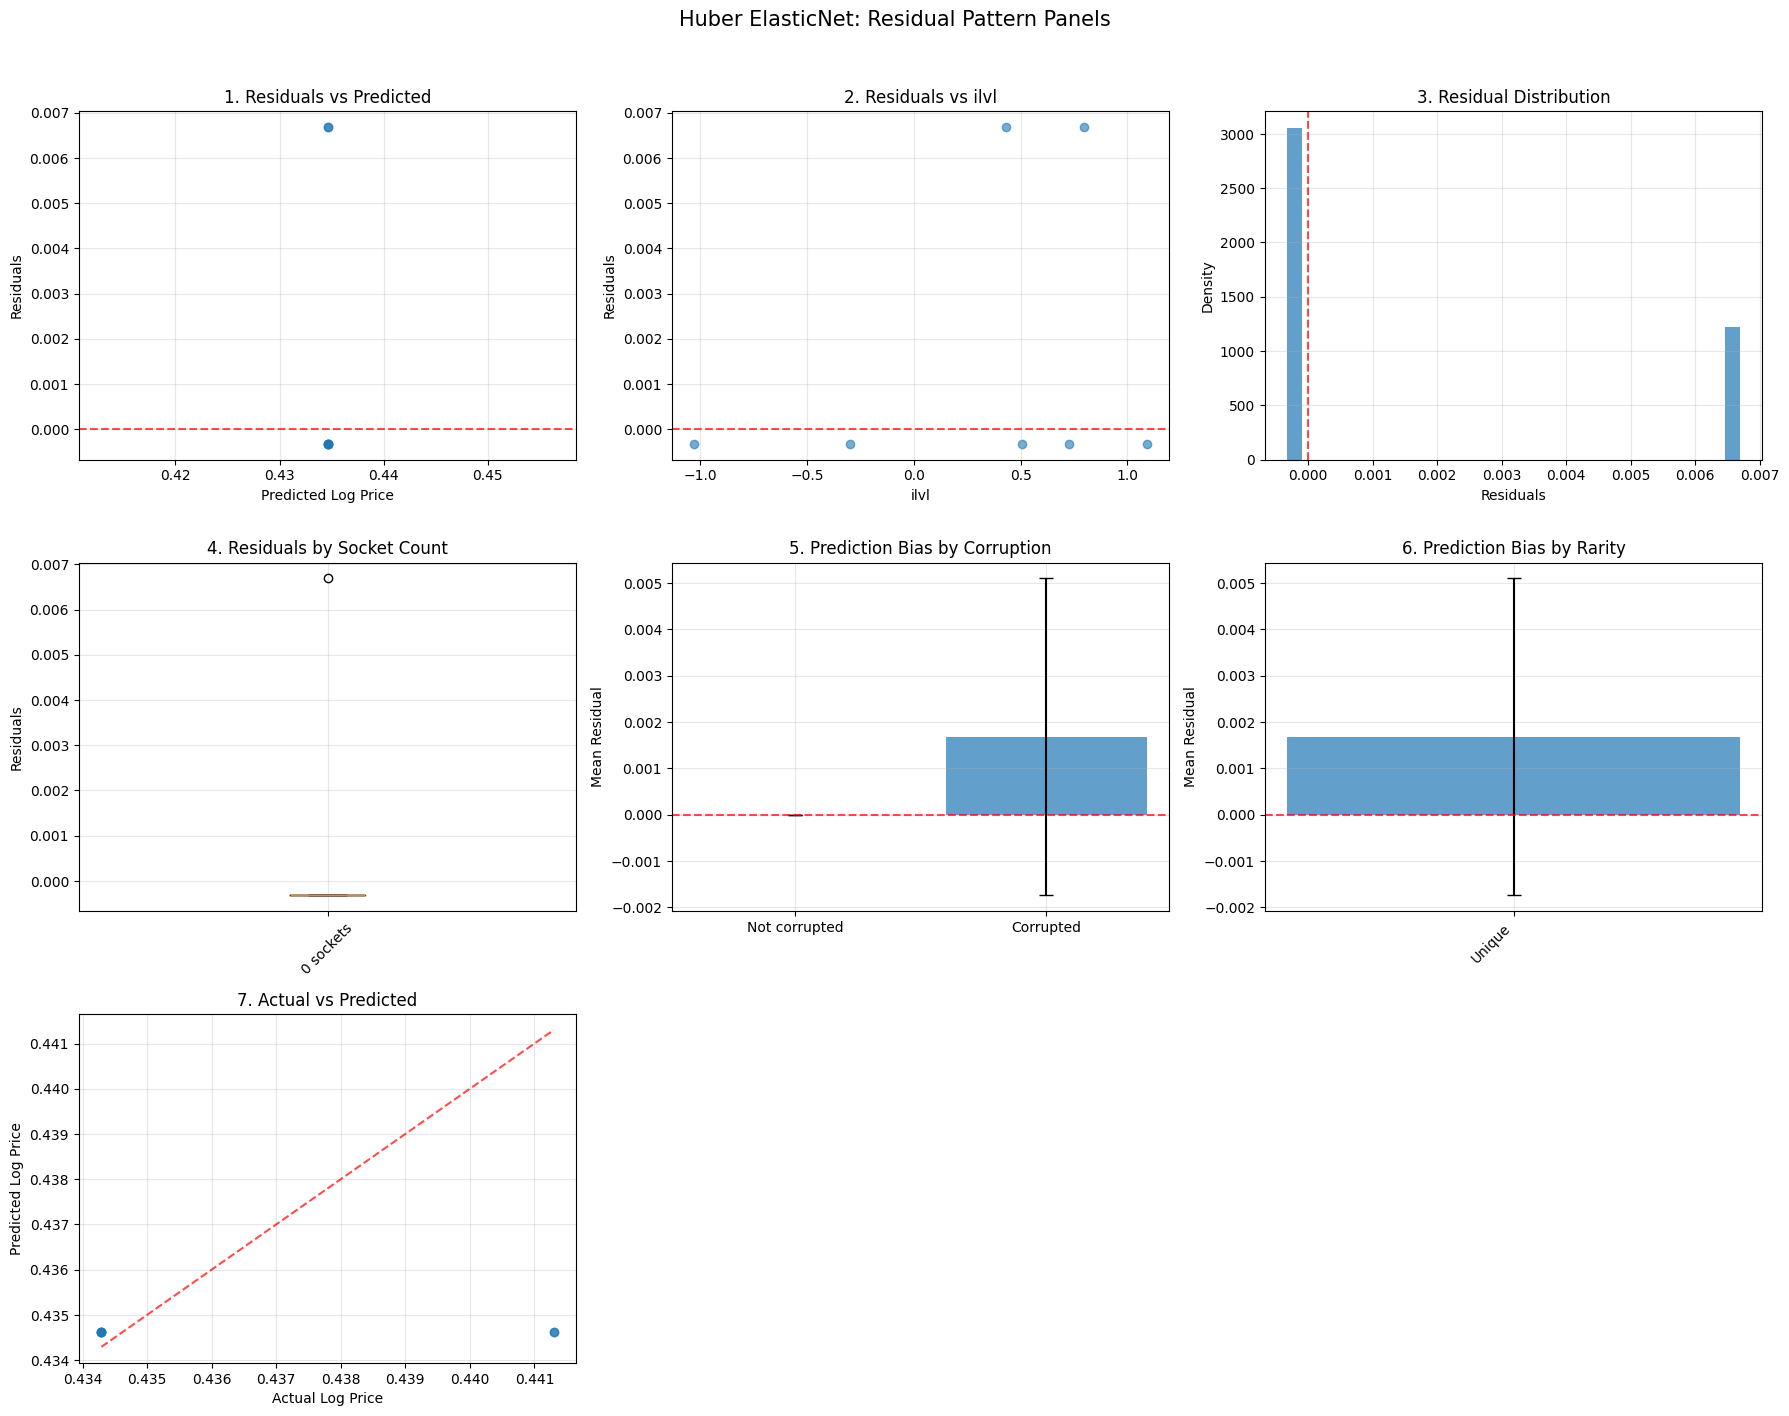


=== Regularized Models (Huber, Pipelines): Comparison ===
          model  best_alpha  best_l1_ratio  cv_mean_r2  cv_std_r2  test_r2  test_rmse  test_mae
     HuberRidge      0.0051            NaN      0.5500     0.5568   1.0000     0.0000    0.0000
HuberElasticNet      0.0100         0.1500     -0.0634     0.0991  -0.2825     0.0036    0.0021
Comparison of Regularized Models for Enezun's Charge:

=== Huber+Ridge (grid search, Pipeline) ===
Best params: {'huber__alpha': np.float64(10.0)} | CV R² mean=-0.1719 ± 0.3412
r2_train: 0.1129
r2_test: -0.7303
rmse_test: 0.9217
mae_test: 0.7504

Top coefficients (|value|):
       feature  coefficient  abs_coefficient
          ilvl    -0.192797         0.192797
       quality     0.145153         0.145153
  socket_count     0.067876         0.067876
  is_corrupted    -0.031334         0.031334
open_slots_est     0.028010         0.028010


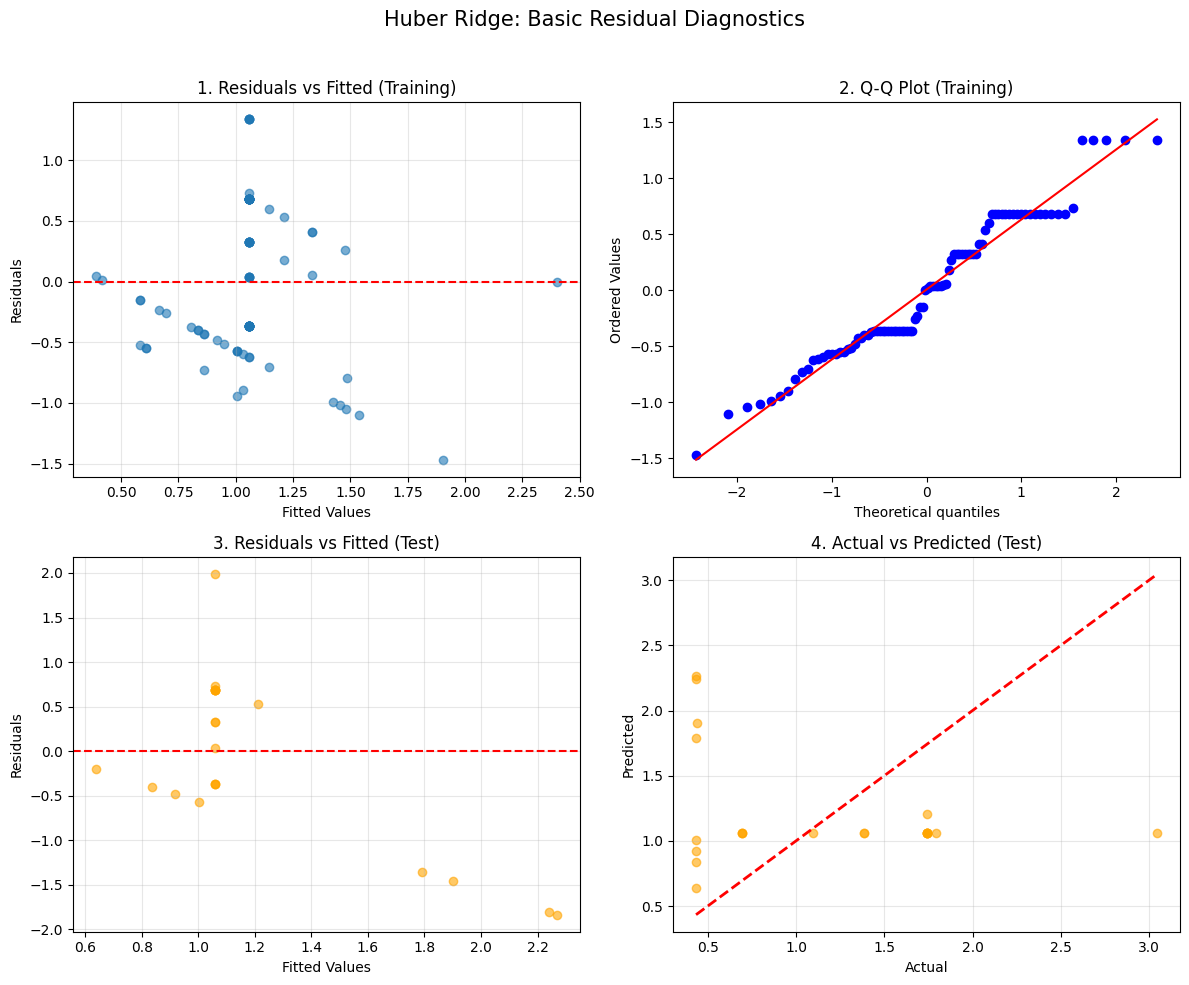

Huber Ridge PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.7303
Mean Absolute Error: 0.7504
Root Mean Squared Error: 0.9217


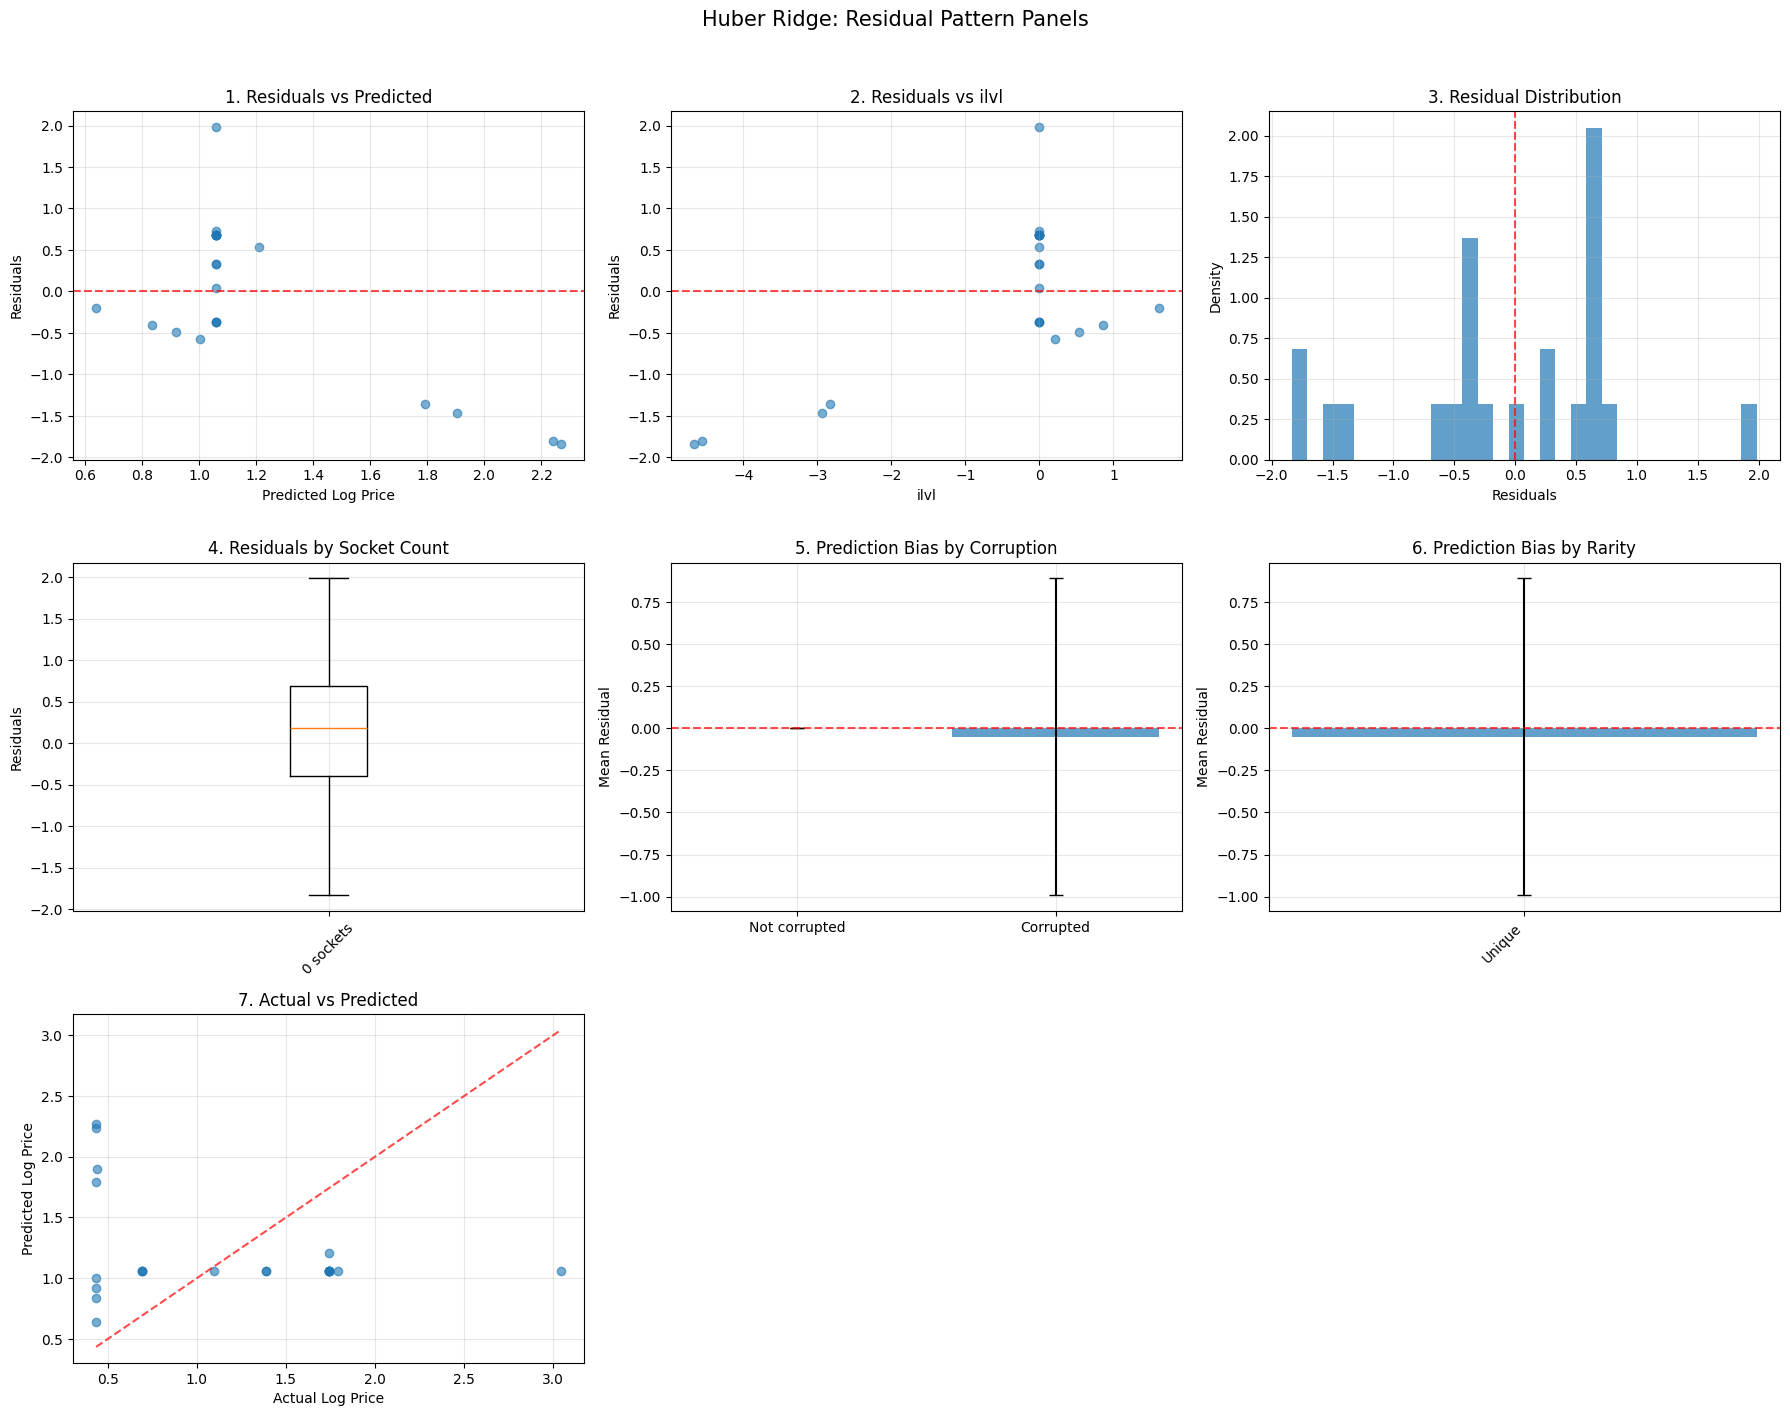


=== Huber+ElasticNet (grid search, Pipeline) ===
Best params: {'sgd__alpha': np.float64(0.01), 'sgd__l1_ratio': 0.15} | CV R² mean=-0.1921 ± 0.2474
r2_train: 0.0489
r2_test: -0.4425
rmse_test: 0.8416
mae_test: 0.7154

Non-zero coefficients: 1/5

Top coefficients (|value|):
       feature  coefficient  abs_coefficient
          ilvl    -0.136717         0.136717
  socket_count     0.000000         0.000000
       quality     0.000000         0.000000
  is_corrupted     0.000000         0.000000
open_slots_est     0.000000         0.000000


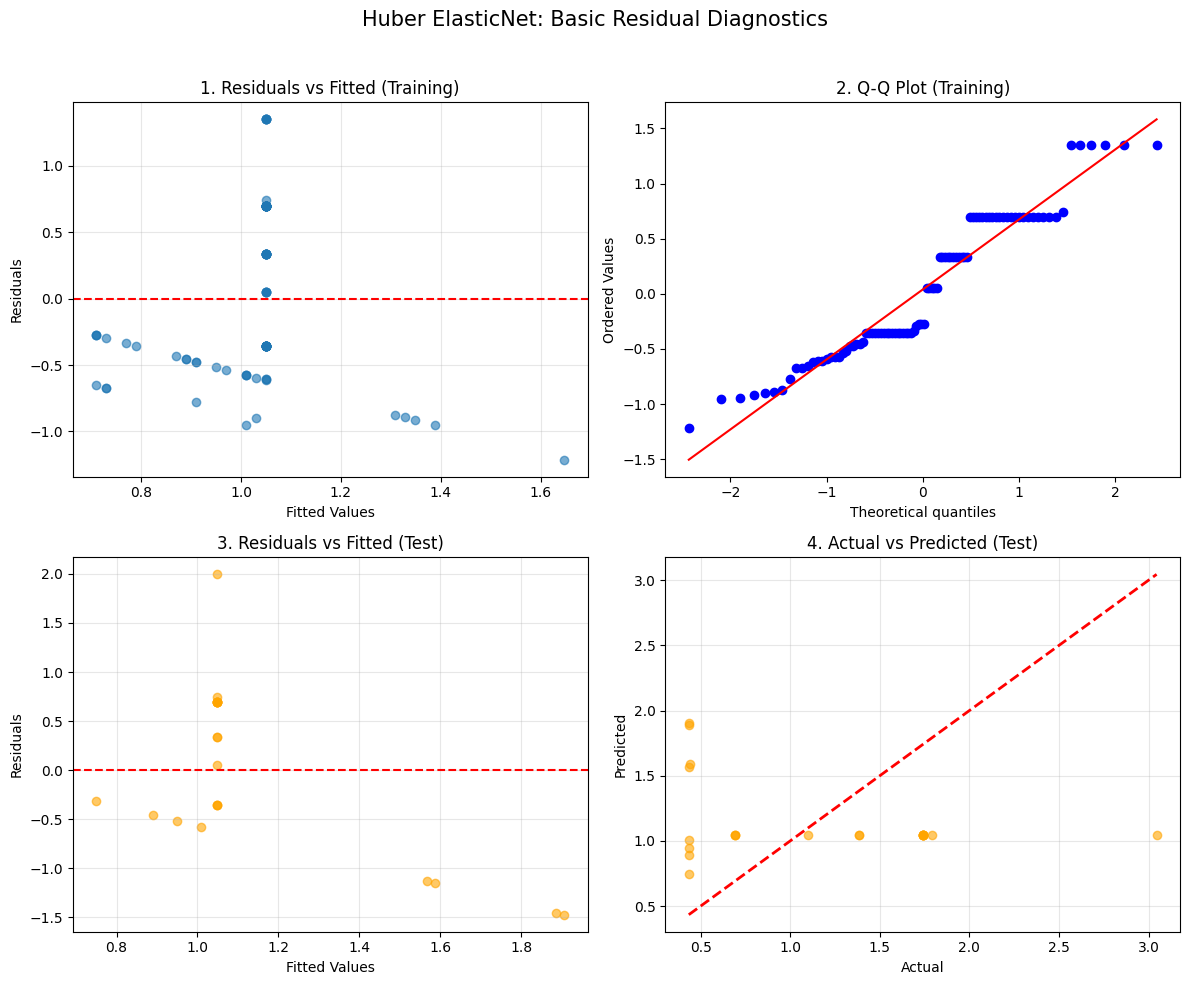

Huber ElasticNet PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.4425
Mean Absolute Error: 0.7154
Root Mean Squared Error: 0.8416


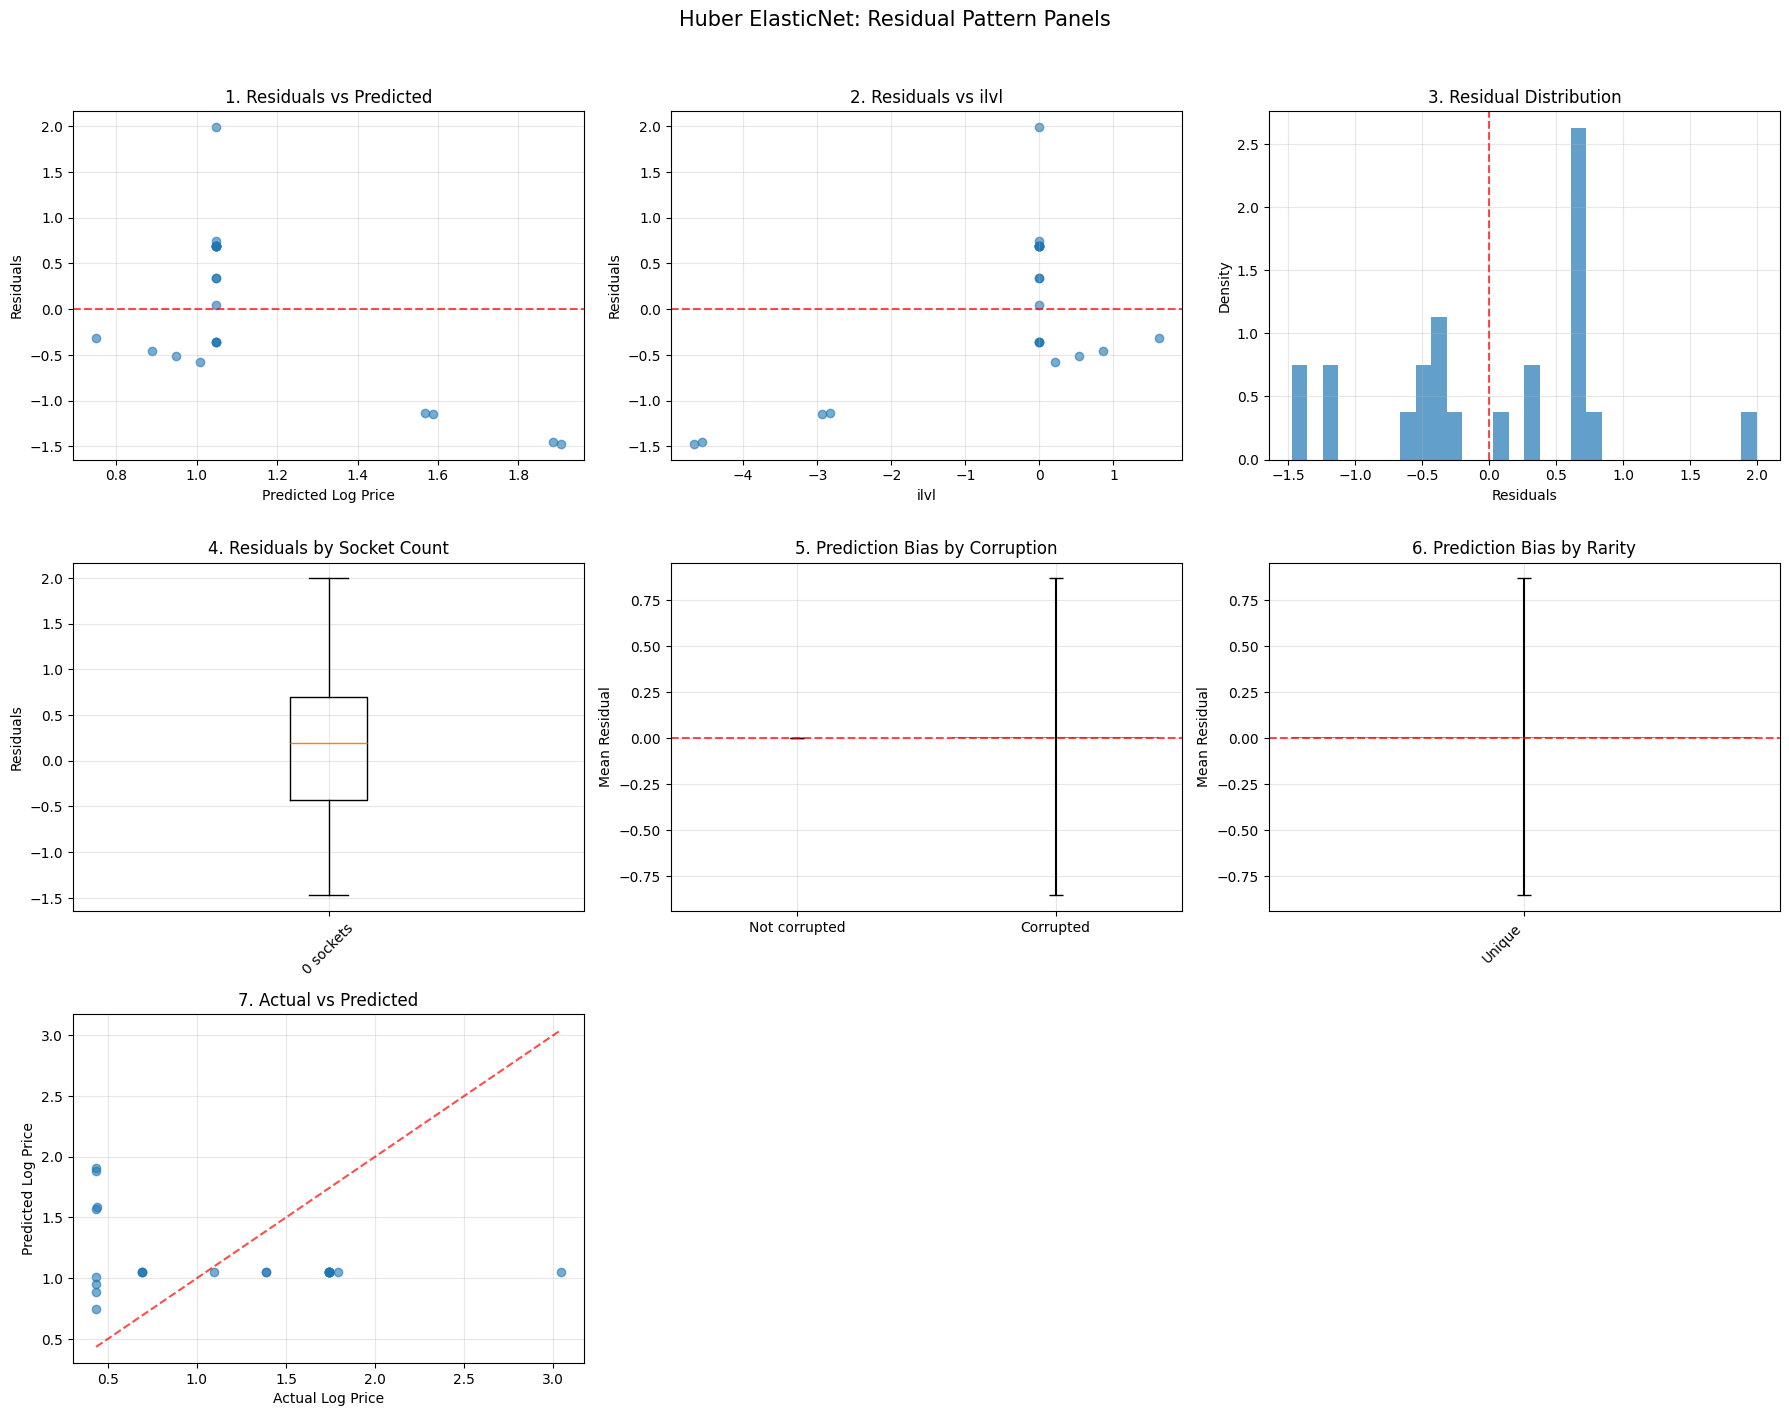


=== Regularized Models (Huber, Pipelines): Comparison ===
          model  best_alpha  best_l1_ratio  cv_mean_r2  cv_std_r2  test_r2  test_rmse  test_mae
     HuberRidge     10.0000            NaN     -0.1719     0.3412  -0.7303     0.9217    0.7504
HuberElasticNet      0.0100         0.1500     -0.1921     0.2474  -0.4425     0.8416    0.7154
Comparison of Regularized Models for Lifesprig:

=== Huber+Ridge (grid search, Pipeline) ===
Best params: {'huber__alpha': np.float64(10.0)} | CV R² mean=-0.1437 ± 0.2145
r2_train: 0.0437
r2_test: 0.0687
rmse_test: 0.7272
mae_test: 0.4969

Top coefficients (|value|):
       feature  coefficient  abs_coefficient
          ilvl     0.104796         0.104796
open_slots_est     0.091492         0.091492
      max_mana    -0.063328         0.063328
       quality     0.045330         0.045330
  socket_count     0.036042         0.036042


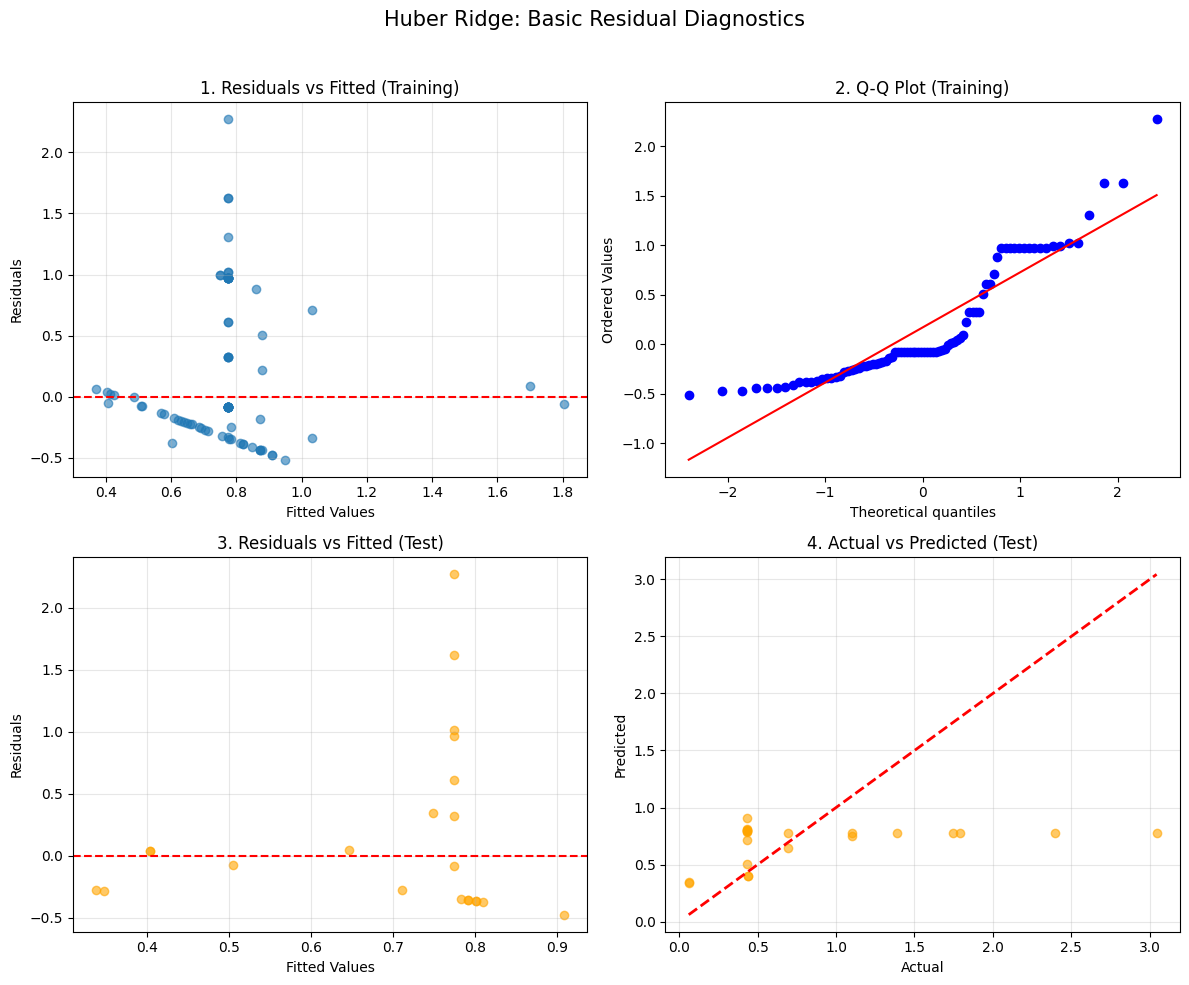

Huber Ridge PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.0687
Mean Absolute Error: 0.4969
Root Mean Squared Error: 0.7272


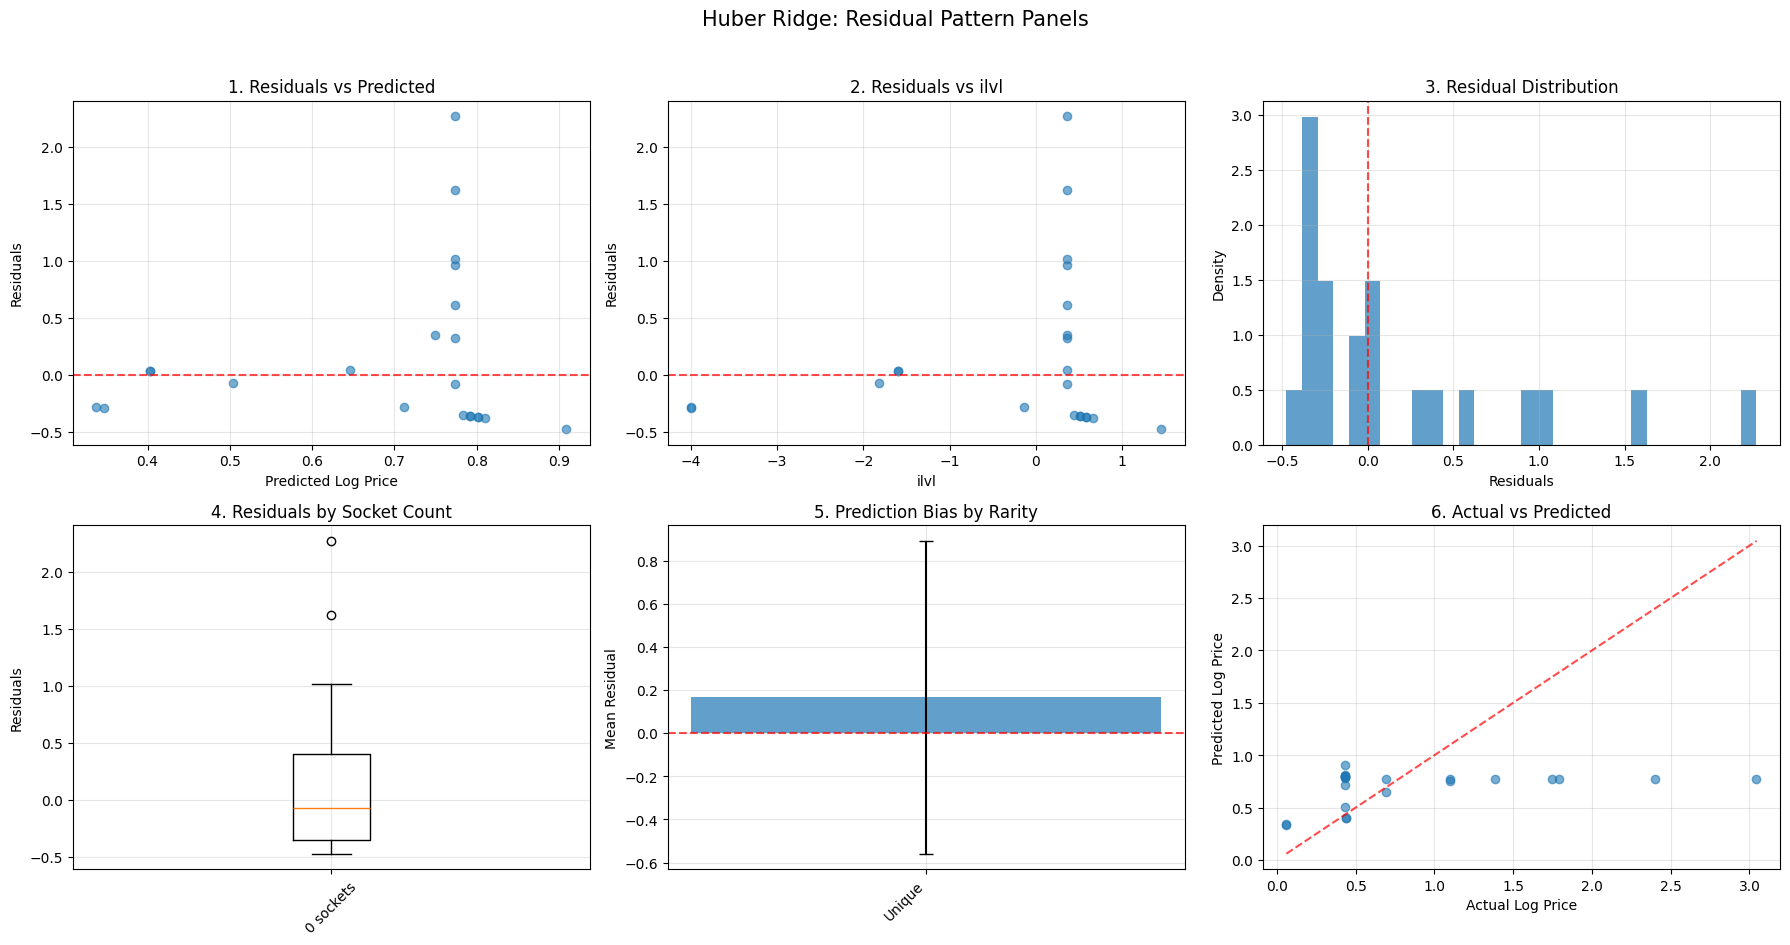


=== Huber+ElasticNet (grid search, Pipeline) ===
Best params: {'sgd__alpha': np.float64(0.003593813663804626), 'sgd__l1_ratio': 0.95} | CV R² mean=-0.1755 ± 0.2599
r2_train: -0.5427
r2_test: -0.2839
rmse_test: 0.8539
mae_test: 0.7298

Non-zero coefficients: 2/5

Top coefficients (|value|):
       feature  coefficient  abs_coefficient
          ilvl     0.267140         0.267140
      max_mana    -0.167253         0.167253
  socket_count     0.000000         0.000000
       quality     0.000000         0.000000
open_slots_est     0.000000         0.000000


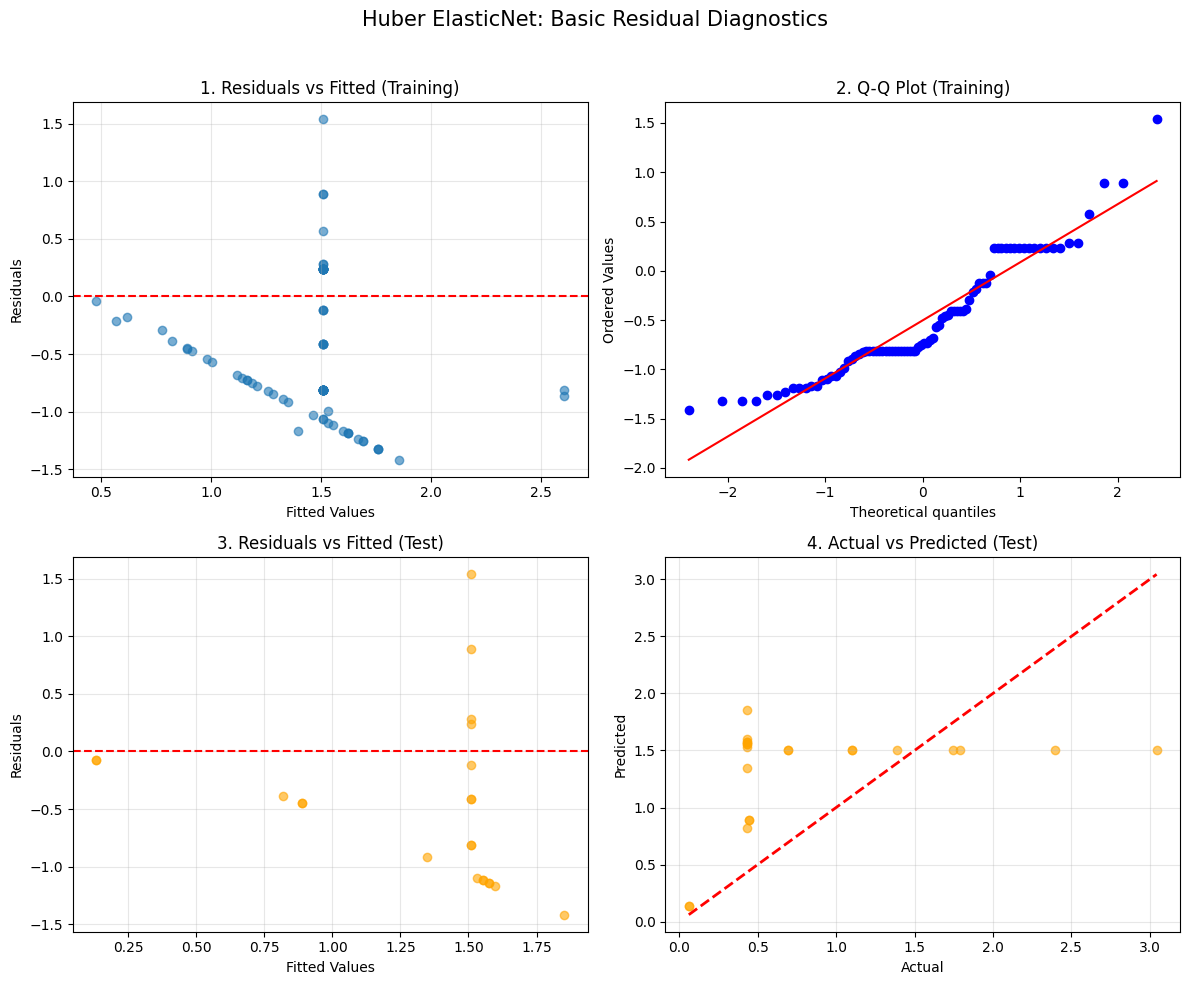

Huber ElasticNet PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.2839
Mean Absolute Error: 0.7298
Root Mean Squared Error: 0.8539


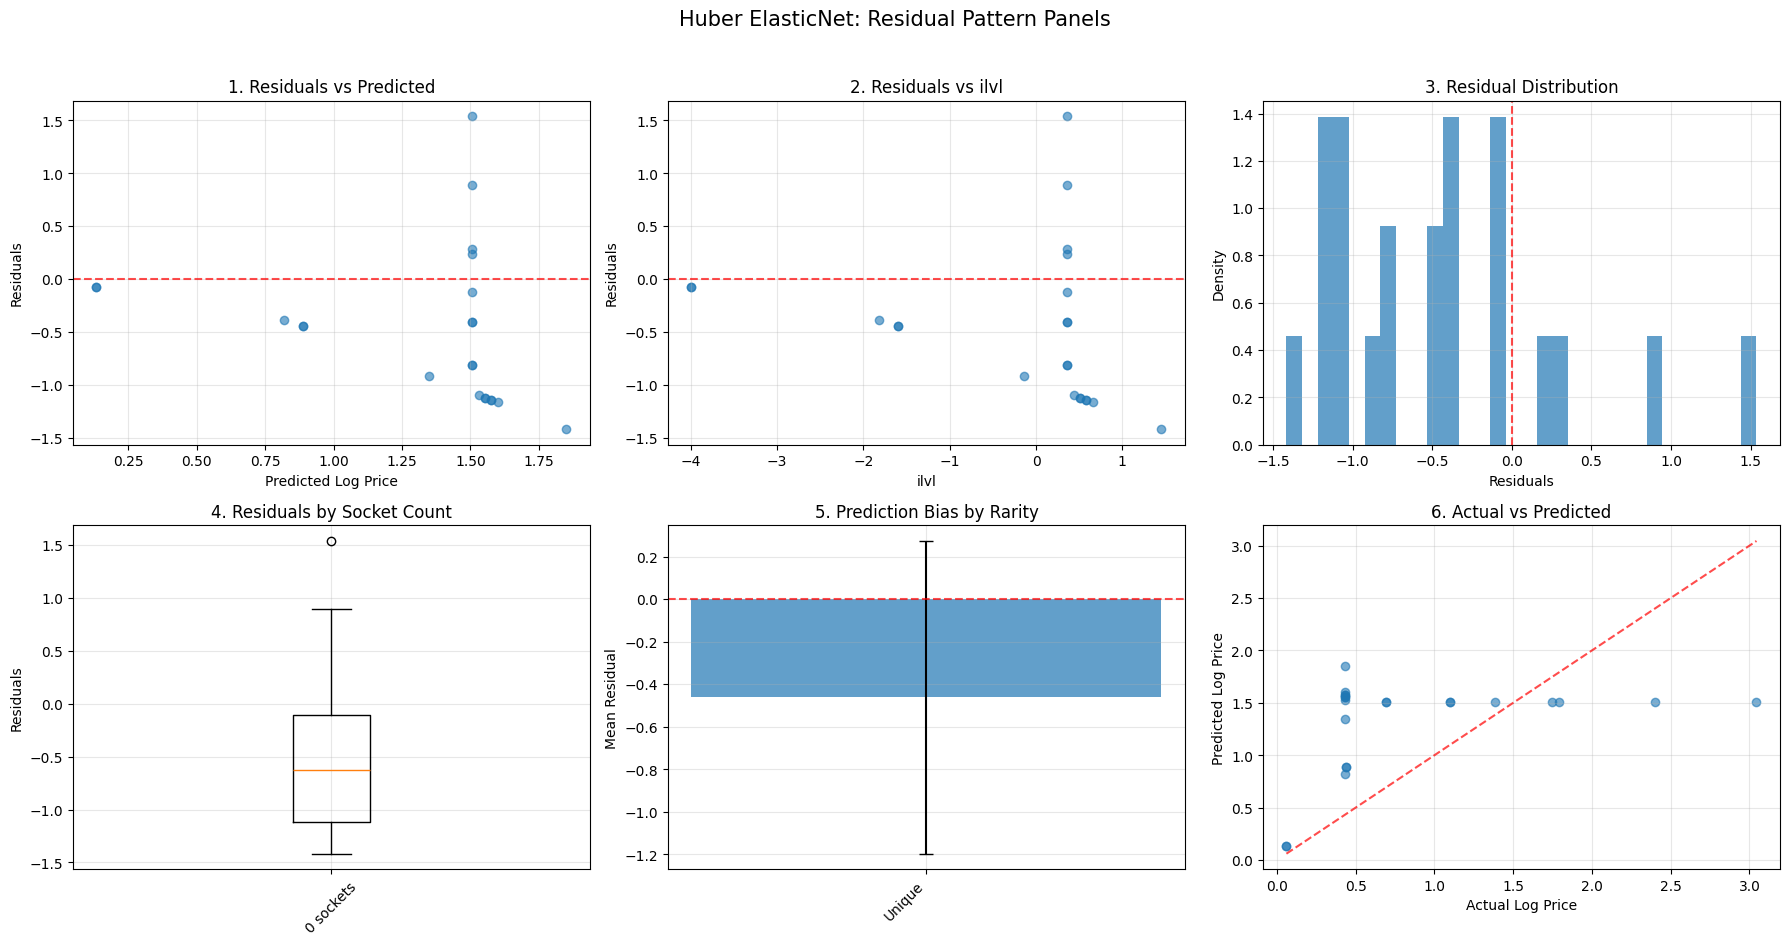


=== Regularized Models (Huber, Pipelines): Comparison ===
          model  best_alpha  best_l1_ratio  cv_mean_r2  cv_std_r2  test_r2  test_rmse  test_mae
     HuberRidge     10.0000            NaN     -0.1437     0.2145   0.0687     0.7272    0.4969
HuberElasticNet      0.0036         0.9500     -0.1755     0.2599  -0.2839     0.8539    0.7298
Comparison of Regularized Models for Sanguine Diviner:

=== Huber+Ridge (grid search, Pipeline) ===
Best params: {'huber__alpha': np.float64(3.874675120456128)} | CV R² mean=-0.2349 ± 0.1229
r2_train: 0.1697
r2_test: 0.6207
rmse_test: 0.2022
mae_test: 0.0646

Top coefficients (|value|):
         feature   coefficient  abs_coefficient
         quality  2.587842e-01     2.587842e-01
attack_speed_pct -5.641504e-02     5.641504e-02
  open_slots_est  1.532873e-06     1.532873e-06
            ilvl -4.839903e-07     4.839903e-07
    socket_count  2.045173e-07     2.045173e-07


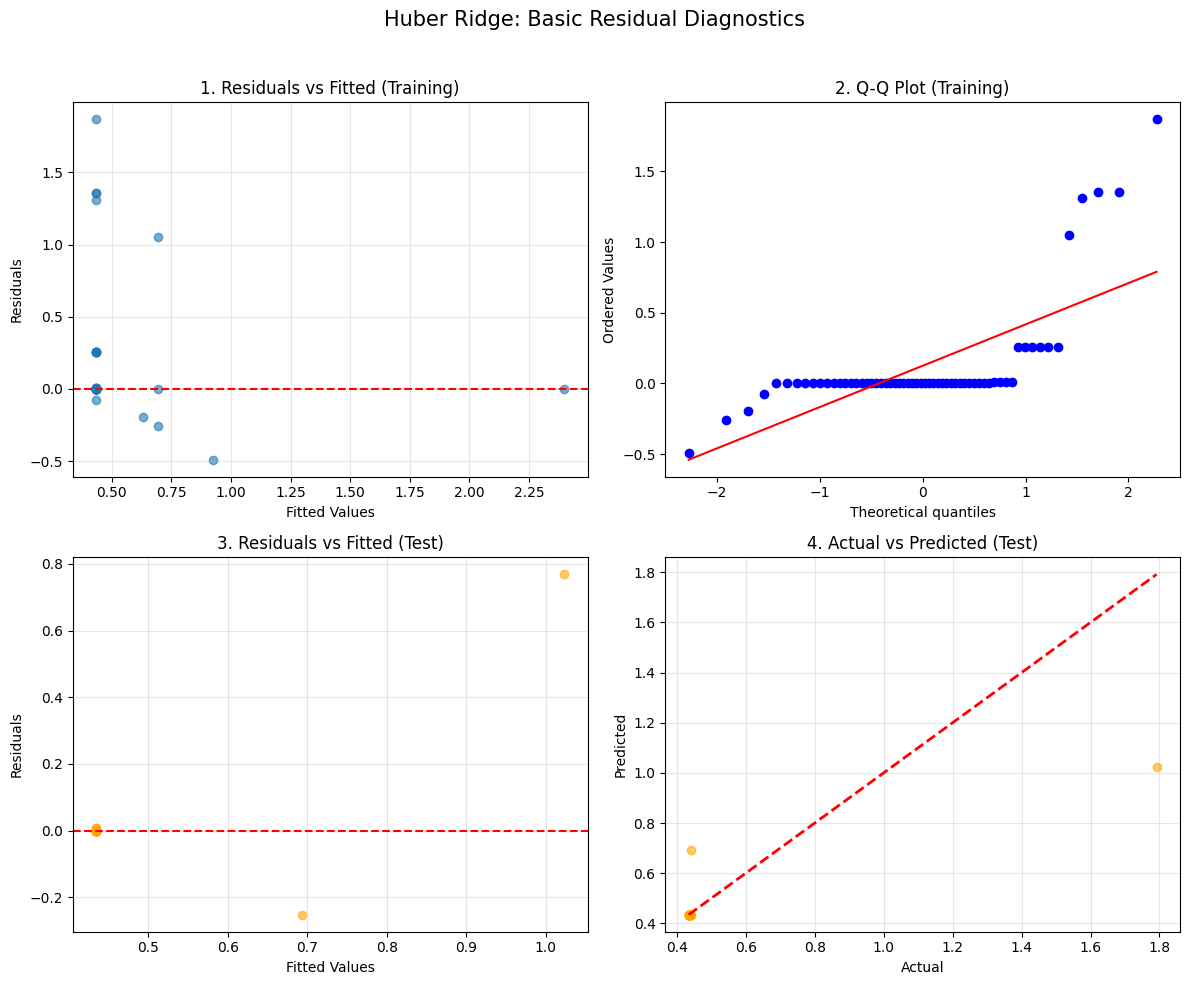

Huber Ridge PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.6207
Mean Absolute Error: 0.0646
Root Mean Squared Error: 0.2022


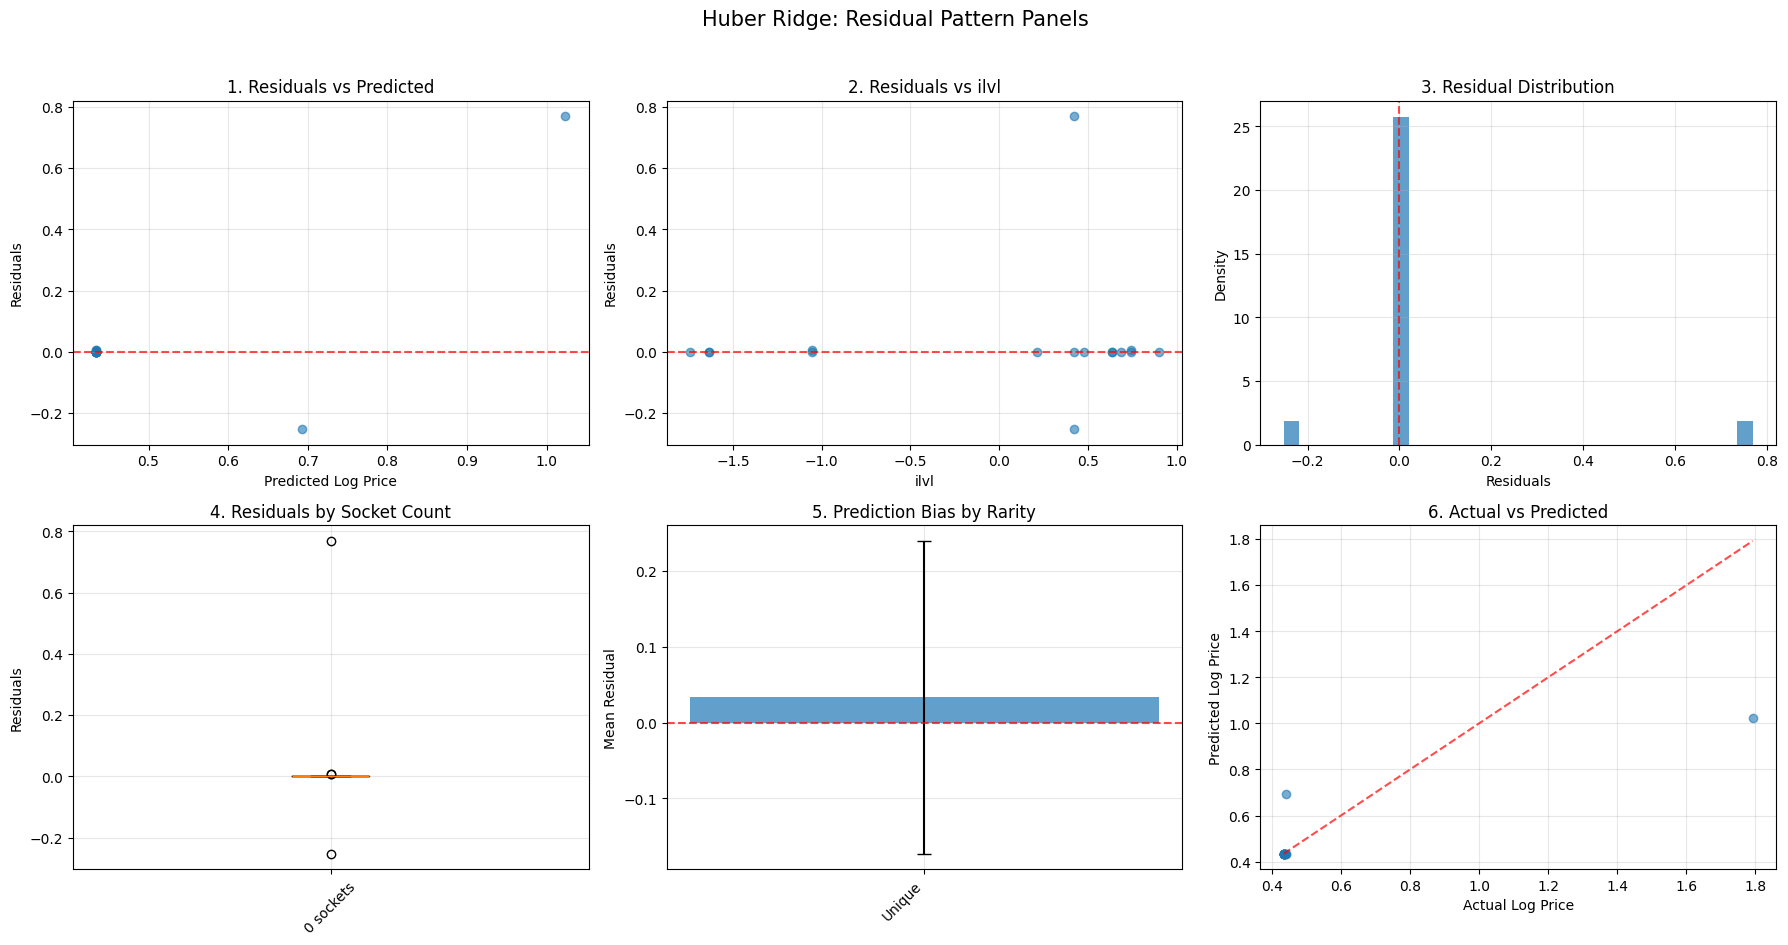


=== Huber+ElasticNet (grid search, Pipeline) ===
Best params: {'sgd__alpha': np.float64(0.01), 'sgd__l1_ratio': 0.7} | CV R² mean=-58.6886 ± 113.2032
r2_train: 0.1839
r2_test: 0.4968
rmse_test: 0.2329
mae_test: 0.1263

Non-zero coefficients: 1/5

Top coefficients (|value|):
         feature  coefficient  abs_coefficient
         quality     0.174125         0.174125
            ilvl     0.000000         0.000000
    socket_count     0.000000         0.000000
attack_speed_pct     0.000000         0.000000
  open_slots_est     0.000000         0.000000


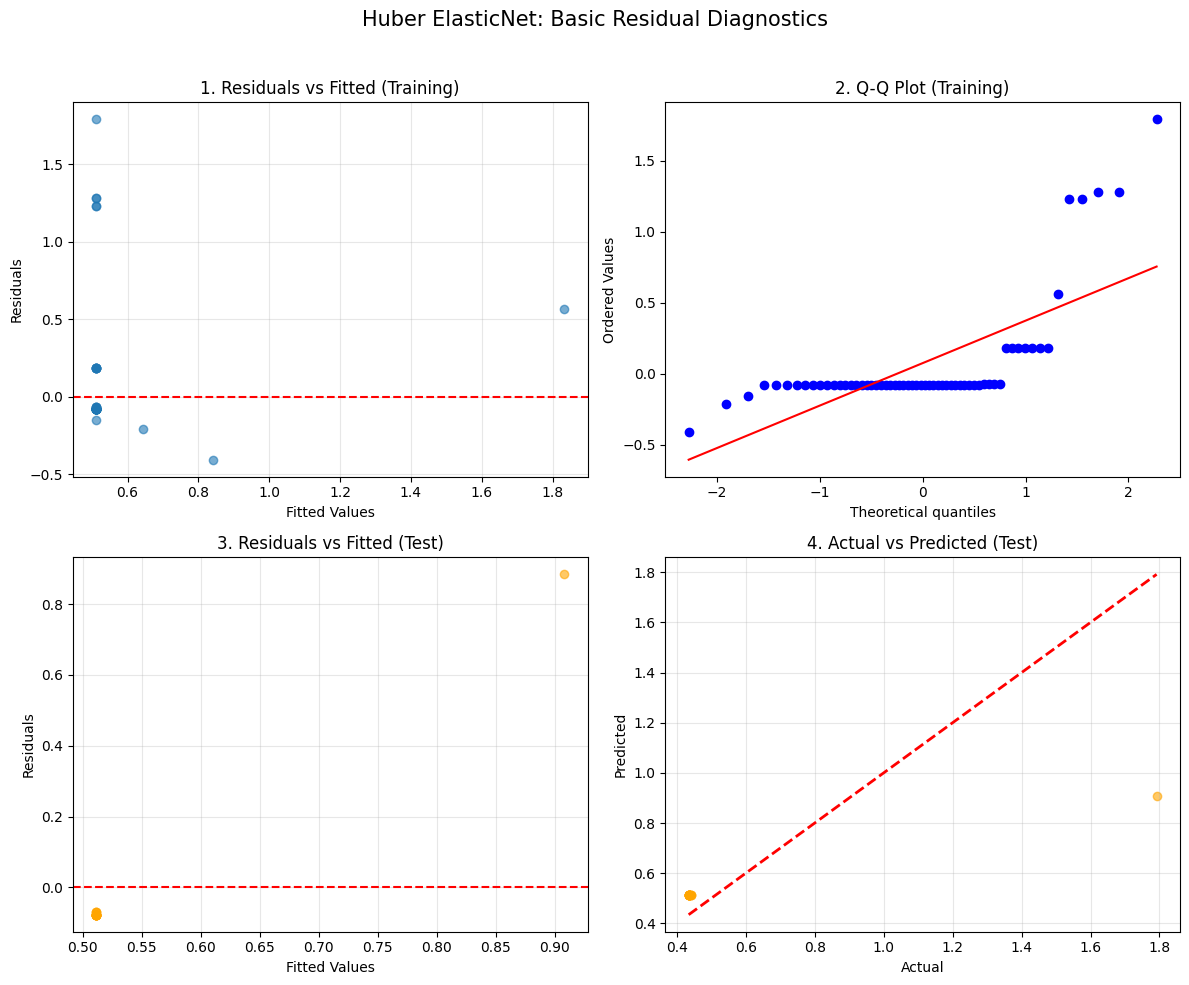

Huber ElasticNet PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.4968
Mean Absolute Error: 0.1263
Root Mean Squared Error: 0.2329


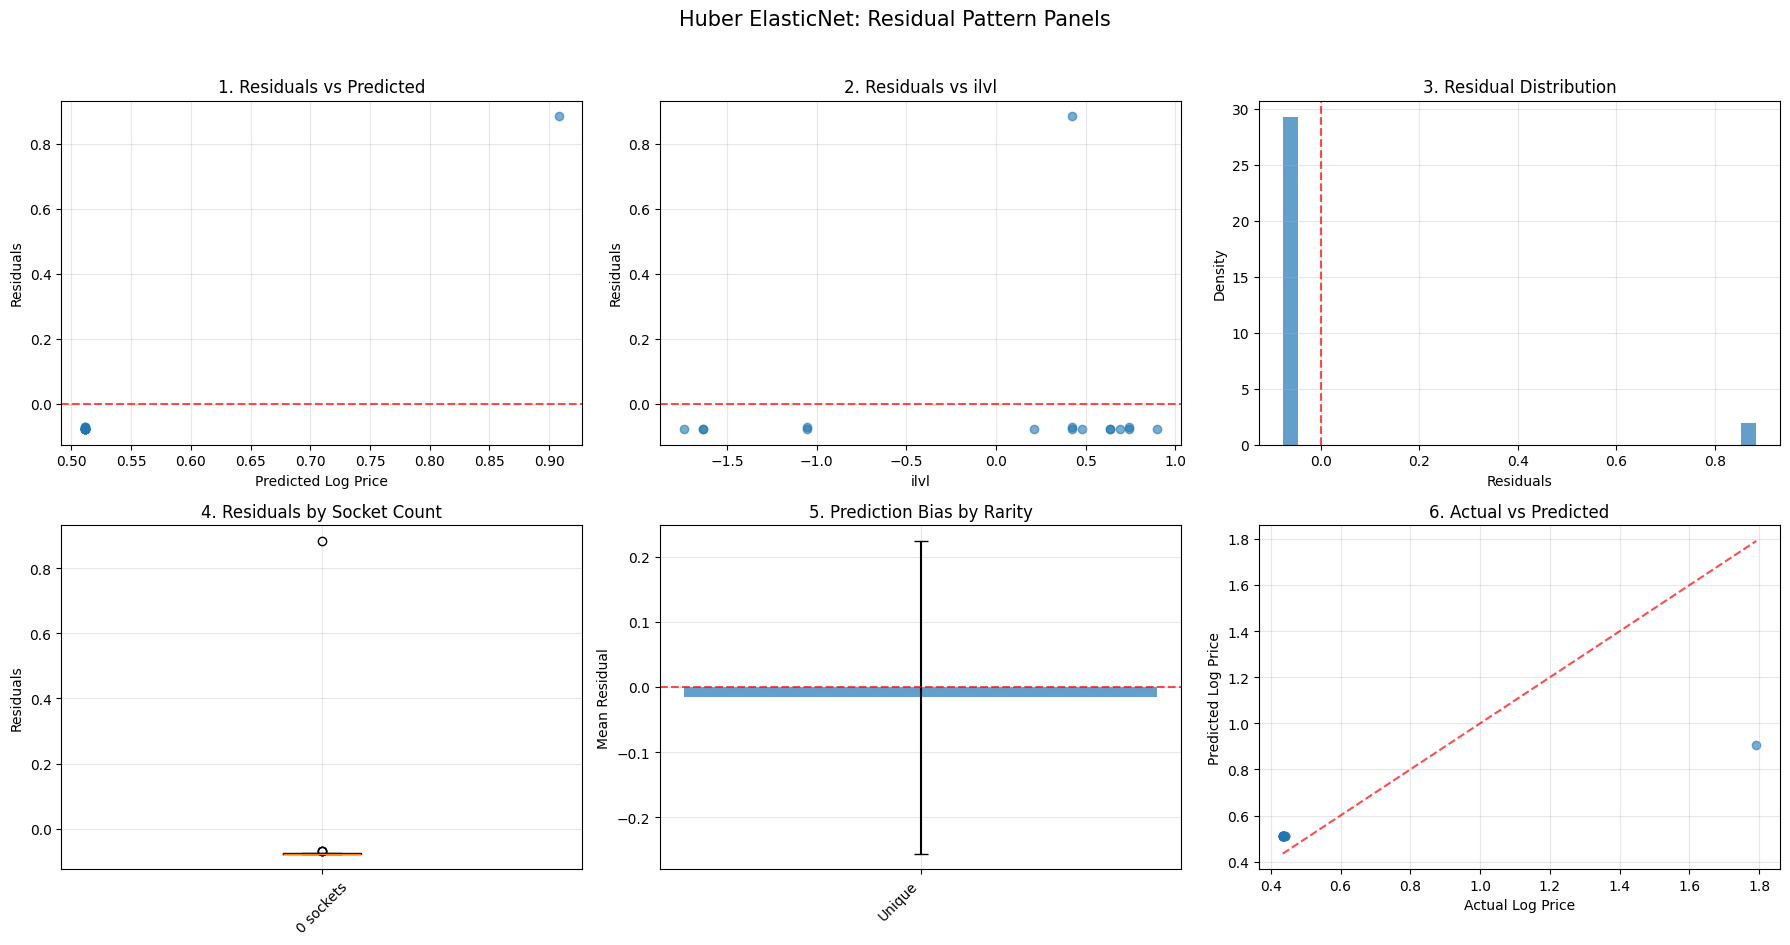


=== Regularized Models (Huber, Pipelines): Comparison ===
          model  best_alpha  best_l1_ratio  cv_mean_r2  cv_std_r2  test_r2  test_rmse  test_mae
     HuberRidge      3.8747            NaN     -0.2349     0.1229   0.6207     0.2022    0.0646
HuberElasticNet      0.0100         0.7000    -58.6886   113.2032   0.4968     0.2329    0.1263
Comparison of Regularized Models for The Wicked Quill:


ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Iterate through each unique item in the dictionary and compare regularized models
for name, data in unique_item_features.items():
    print(f"Comparison of Regularized Models for {name}:")
    X_unique = data["features"]
    y_unique = data["target"]
    unique_meta = data["metadata"]
    
    # Compare regularized models for the current unique item
    cmp = compare_regularized_models(
        X_unique, y_unique["log_price"], metadata=unique_meta,
        ridge_alphas=np.logspace(-6, 1, 18),
        en_alphas=np.logspace(-6, -2, 10),
        en_l1_ratios=[0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95],
        cv_splits=5, test_size=0.2, random_state=42, n_jobs=-1, epsilon=1.35, plots=True
    )
    
    # Output the comparison results for each unique item